# Car brands detector
Image classification task with the usage of CNN for Data Science Bootcamp's final project organized by Sages.

# Table of contents
1. [Introduction](#1)
2. [Packages](#2)
3. [Dataset - official overview and storage requirements](#3)
4. [Data exploration](#4)
    1. [Verification](#4A)
        1. [car_annos.mat file](#4Aa)
        2. [car_ims subfolder](#4Ab)
        3. [Dataset verification](#4Ac)
    2. [Statistics](#4B)
5. [Custom preprocessing and structurization of a dataset](#5)
6. [Building a tensorflow dataset](#6)
7. [Training multiple models](#7)
    1. [ResNet50](#7A)
    2. [InceptionV3](#7B)
    3. [MobileNetV2](#7C)
    4. [VGG19](#7D)
8. [Learning process analysys](#8)
9. [Performance on test set](#9)
    1. [Total accuracy scores](#9A)
    2. [Comparison of accuracy scores for the best and the worst categories (each one model vs rest)](#9B)
        1. [Best categories for each model compared to the same categories of other models (cropped images)](#9Ba)
        2. [Worst categories for each model compared to the same classes of other models (cropped images)](#9Bb)
        3. [Best categories for each model compared to the same classes of other models (orginal resolution images)](#9Bc)
        4. [Worst categories for each model compared to the same classes of other models (orginal resolution images)](#9Bd)
    3. [Comparison of the same models on different test sets (cropped vs orginal resolution)](#9C)
        1. [Best categories on cropped images test set](#9Ca)
        2. [Worst categories on cropped images test set](#9Cb)
        3. [Best categories on  test set with orginal image resolution](#9Cc)
        4. [Worst categories on test set with orginal image resolution](#9Cd)
10. [Fine-tuning the best models](#10)
    1. [ResNet50 fine-tuning](#10A)
    2.  [MobileNetV2 fine-tuning](#10B)
11. [Visualization of learning process improvement](#11)
12. [Fine-tuned models perforamnce on a test set](#12)
    1. [Total accuracy scores](#12A)
    2. [How exactly categories did improve](#12B)
13. [Testing hypothesic from section Statistics (4B)](#13)
14. [Predictions on images from test set (visualization)](#14)
15. [Summary](#15)

<a name='1'></a>
## 1. Introduction
The project goal is to classify a brand of car based on its image. To build a model, the transfer learning method will be used. Pretrained models that are taken into consideration in this project are as follows:
* ResNet50
* InceptionV3
* MobileNetV2
* VGG19

Moreover, some necessary changes will be applied to top layers of pretrained models to match the requirements of specific dataset. Later on, fine-tuning will be used, to improve models that have the most potential.

The data for this project is available here - <a href="https://ai.stanford.edu/~jkrause/cars/car_dataset.html">Cars Dataset by Stanford University</a>. The version of dataset is the one from section **Download -> Update**.

<a name='2'></a>
## 2. Packages
Run the cell below to import packages that are needed in this for this project

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import pickle
import sklearn.metrics

<a name='3'></a>
## 3. Dataset - official overview and storage requirements

Official information that can be found on a website of <a href="https://ai.stanford.edu/~jkrause/cars/car_dataset.html">Stanford Cars Dataset</a> provides a quick overview:

"*The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.*"

Additionally, there is a file that contains information about "*all bounding boxes and labels for both training and test*" examples. This file is named *car_annos*.

**Important:**

After downloading tar file of all images (section Download -> Update), please unpack all images and store them in *dataset_original/car_ims* so the directory looks as follows:


<div style="padding-left: 30px;">
    
    - dataset_original/
        -car_ims/
            *all images should be stored here*
        - cars_annos.mat
</div>

*cars_annos.mat* file is already provided in this repository.

<a name='4'></a>
## 4. Data exploration
This section is dedicated to data exploration and it will be splitted into two subsections - verification and statistics.

After section is presented, questions below are going to be answered and some hypothesis will be raised:

**Verification**:

- how exactly information about an image is stored?
- do all images have the same resolution?
- are all images three dimensional?
- does dataset match its official overview?

**Statistics**:
- does the number of examples in each class vary and if so, how?
- how the quantity of examples in each class may affect model accuracy?

Before we start, let define some global variables:


In [2]:
dataset_original_directory = "dataset_original"
images_directory = "car_ims"
annos_file_name = "cars_annos.mat"

path_ims_original = os.path.join(dataset_original_directory, images_directory)
path_annos = os.path.join(dataset_original_directory, annos_file_name)

<a name='4A'></a>
### A. Verification
To verify if provided information on the official website matches the dataset, each component should be analyzed.

<a name='4Aa'></a>
#### a) cars_annos.mat file
After loading ***cars_annos.mat*** file, it can be observed that it contains dictionary class object. Let's see what keys can be found:

In [3]:
annos_file  = scipy.io.loadmat(path_annos)
print(f"Type of an annos file:\t {type(annos_file)}")
print(f"Keys of an annos file:\t {annos_file.keys()}")

Type of an annos file:	 <class 'dict'>
Keys of an annos file:	 dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])


*annotations* and *class_names* keys are the ones bringing the most attention. Following lines will check what these keys hide and how.

In [4]:
print(f"Type of an object stored as value of 'annotations' key:\t {type(annos_file['annotations'])}")
print(f"Shape of object: {annos_file['annotations'].shape}")
print(f"\nDtype of an object stored in value of 'annotations' key:\n{annos_file['annotations'].dtype}")

Type of an object stored as value of 'annotations' key:	 <class 'numpy.ndarray'>
Shape of object: (1, 16185)

Dtype of an object stored in value of 'annotations' key:
[('relative_im_path', 'O'), ('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('test', 'O')]


In [5]:
print(f"Type of an object stored as value of 'class_name' key:\t{type(annos_file['class_names'])}")
print(f"Shape of object: {annos_file['class_names'].shape}")
print(f"\nFirst five lines of an object stored in 'class_name' key:\n{annos_file['class_names'][0][:5]}")

Type of an object stored as value of 'class_name' key:	<class 'numpy.ndarray'>
Shape of object: (1, 196)

First five lines of an object stored in 'class_name' key:
[array(['AM General Hummer SUV 2000'], dtype='<U26')
 array(['Acura RL Sedan 2012'], dtype='<U19')
 array(['Acura TL Sedan 2012'], dtype='<U19')
 array(['Acura TL Type-S 2008'], dtype='<U20')
 array(['Acura TSX Sedan 2012'], dtype='<U20')]


**Conclusions (*car_annos.mat* file)**:

**'annotations' key**
* the value of an 'annotations' key is an numpy.ndarray object
* this object contains one row and 16185 colums (shape 1, 16185)
* each column contains following data: *relative_im_path, bbox_x1, bbox_y1, bbox_x2, bbox_y2, class, test*

**'class_names' key**
* the value of an 'class_names' key is an numpy.ndarray object
* this object contains one rown and 196 columns (shape 1, 196)
* each column provides information about which class is which car, for example class 0 indicates 'AM General Hummer SUV 2000' car

<a name='4Ab'></a>
#### b) car_ims subfolder
After going through car_ims subfolder, conclusion that all files do not have the same resolution can be drawn. Below, an example file will be shown to understand dataset more clearly.

Frist of all, get *relative_im_path, bbox_x1, bbox_y1, bbox_x2, bbox_y2, class, test* data of one example:

In [6]:
n_example = int(np.random.randint(16185, size=1))
relative_im_path = annos_file["annotations"]["relative_im_path"][0][n_example][0]
bbox_x1 = int(annos_file["annotations"]["bbox_x1"][0][n_example])
bbox_y1 = int(annos_file["annotations"]["bbox_y1"][0][n_example])
bbox_x2 = int(annos_file["annotations"]["bbox_x2"][0][n_example])
bbox_y2 = int(annos_file["annotations"]["bbox_y2"][0][n_example])
img_class = int(annos_file["annotations"]["class"][0][n_example])
img_test = annos_file["annotations"]["test"][0][n_example]

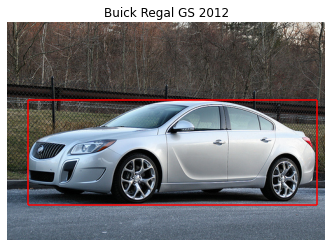

Dimensions of an image: 3


In [7]:
example_path = os.path.join(dataset_original_directory, relative_im_path)
img = plt.imread(example_path)
img_car_brand = annos_file['class_names'][0][img_class - 1][0] 
# '-1'  in the line above because 'class' has values from 1 to 196 whereas "class_names" list starts at 0 and ends at 195
# it will be shown later

plt.title(img_car_brand)
plt.imshow(img)
plt.hlines([bbox_y1, bbox_y2], bbox_x1, bbox_x2,  colors="red")
plt.vlines([bbox_x1, bbox_x2], bbox_y1, bbox_y2, colors="red")
plt.axis('off')
plt.show()

print(f"Dimensions of an image: {img.ndim}")

The image above has 3 dimensions. Later on, the hypothesis that all images are 3 dimensional will be tested.

<a name='4Ac'></a>
#### c) Dataset verification
Hypothesis:
* 16185 images (official information)
* 196 classes of cars (official information)
* dataset split: 8144 examples in training set and 8041 in test set (official information). There is a need to find out which set indicates 0 and 1
* class has been split roughly in a 50-50 split (official information)
* all the images are three dimensional (hypothesis from previous chapter)

The function below will verify most of the statments above. ***verify_dataset_and_get_distribution*** function will also output a dataframe that contains a number of examples for each class in training/test set (i.e. distribution of classes). This dataframe will be used to verify, if statement about *50-50 split* is true. What is more, mentioned dataframe will be also needed in "Statistics" section.

In [8]:
def verify_dataset_and_get_distribution(dataset_directory, annotations_file_name, images_directory):
    
    img_dir_path = os.path.join(dataset_directory, images_directory)
    n_ims = len(os.listdir(img_dir_path))

    annotations_path = os.path.join(dataset_directory, annotations_file_name)
    annots = scipy.io.loadmat(annotations_path)["annotations"][0]
    n_annots = len(annots)
    
    dims_3 = True
    other_dims = set()
    car_classes = dict()
    dataset_split_classes = dict()
    car_ds_split_classes = dict()


    for i in range(n_annots):
        current_annot = annots[i]
        
        temp_split_class = int(current_annot["test"])
        if temp_split_class not in dataset_split_classes:
            dataset_split_classes[temp_split_class] = 1
            car_ds_split_classes[temp_split_class] = dict()
        else:
            dataset_split_classes[temp_split_class] += 1
            
        temp_car_class = int(current_annot["class"]) 
        if temp_car_class not in car_classes:
            car_classes[temp_car_class] = 1   
        else:
            car_classes[temp_car_class] += 1        

        if temp_car_class not in car_ds_split_classes[temp_split_class]:
            car_ds_split_classes[temp_split_class][temp_car_class] = 1
        else:
            car_ds_split_classes[temp_split_class][temp_car_class] += 1

        temp_img_path = os.path.join(dataset_directory, current_annot["relative_im_path"][0])
        temp_img = plt.imread(temp_img_path)
        if temp_img.ndim != 3:
            dims_3 = False
            other_dims.add(temp_img.ndim)

    print(f"Quantity of images in subfolder {images_directory}: {n_ims}")
    print(f"Does the quantity of images in subfolder {images_directory} match quantity of image descriptions in {annotations_file_name} file: {n_ims == n_annots}")
    print(f"Class number and quantity of train/test split: {dataset_split_classes}")
    print(f"All images have 3 dimensions: {dims_3}")
    if not dims_3:
        print(f"Other dimensions of images in dataset: {other_dims}")
    print(f"Number of unique car classes: {len(car_classes.keys())}")
    print(f"Car classes: \n{sorted(car_classes.keys())}")
    
    car_brands_distribution = pd.DataFrame.from_dict(data=car_classes, orient='index', columns=["all"])
    for i in range(len(car_ds_split_classes)):
        car_brands_distribution[i] = car_brands_distribution.index.map(car_ds_split_classes[i])
    return car_brands_distribution

In [9]:
car_brands_distribution = verify_dataset_and_get_distribution(dataset_original_directory, annos_file_name,
                                                              images_directory)

Quantity of images in subfolder car_ims: 16185
Does the quantity of images in subfolder car_ims match quantity of image descriptions in cars_annos.mat file: True
Class number and quantity of train/test split: {0: 8144, 1: 8041}
All images have 3 dimensions: False
Other dimensions of images in dataset: {2}
Number of unique car classes: 196
Car classes: 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 15

A class number (0 and 1) and quantity of train/test split compared to official information from Stanford description of dataset, indicate that: 0 - example from a training set, 1 - example from a test set. Columns will be renamed.
What is more, class names (in this case indexes of a dataframe) are going to have values decresed by 1 for the convention.

Let's see dataset distribution and some basic statistics of it.

In [10]:
car_brands_distribution.rename(columns={0 : "train", 1: "test"}, inplace=True)
car_brands_distribution.index = car_brands_distribution.index - 1
print(car_brands_distribution)
print(car_brands_distribution.describe())

     all  train  test
0     89     45    44
1     64     32    32
2     86     43    43
3     84     42    42
4     81     41    40
..   ...    ...   ...
191   85     43    42
192   83     42    41
193   91     46    45
194   86     43    43
195   80     40    40

[196 rows x 3 columns]
              all      train        test
count  196.000000  196.00000  196.000000
mean    82.576531   41.55102   41.025510
std      8.690063    4.33382    4.370573
min     48.000000   24.00000   24.000000
25%     78.750000   39.75000   39.000000
50%     84.000000   42.00000   42.000000
75%     88.000000   44.00000   44.000000
max    136.000000   68.00000   68.000000


Almost all statistics are the same. The exceptions are: mean, std, and 25% (Q1 value), but those statistics have nearly the same values. The description implifies that a statement about *car brand classes are splitted +-50/50 between train and test set* is true.

Let's see from where the difference in mean, std and Q1 value comes from:

In [11]:
quantity_diff_1 = np.all(np.isclose(car_brands_distribution["train"], car_brands_distribution["test"], atol=1))
quantity_not_the_same = 196 - np.isclose(car_brands_distribution["train"], car_brands_distribution["test"], atol=0).sum()
print(f"Do the difference in quantity for each class between train and test set is less than or equal to 1? {quantity_diff_1}")
print(f"How many classes do not have the same quantity (train vs test set)? {quantity_not_the_same}")

Do the difference in quantity for each class between train and test set is less than or equal to 1? True
How many classes do not have the same quantity (train vs test set)? 103


103 classes differ in the number of observations in the train and the test set. A difference is equal to 1 for each one of those classes. The number 103 results directly from the division of the set into training and testing parts: 8144 - 8041 = 103

**Summary of dataset verification**:
* 16185 images (official information confirmed)
* 196 classes i.e. brands of cars (official information confirmed)
* dataset split: 8144 examples in training set and 8041 in test set (official information confirmed)
* class has been split roughly in a 50-50 split (official information confirmed)


* all the images are three dimensional (hypothesis rejected, some of them are 2 dimensional)
* when we refer to a 'test' in annotations file, 0 implies that an observation is from training set and 1 means that it comes from test set

<a name='4B'></a>
### B. Statistics
In this subsection, quantity of classes will be analyzed and some hypothesis will be raised.

In [12]:
def show_distribution(data, sort_by_values=False, figsize=(16, 8)):
    if sort_by_values:
        data = data.sort_values(ignore_index=True)
    desc = data.describe()
    quantiles = [desc["max"], desc["75%"], desc["50%"], desc["25%"]]
    colors = ["#034f84", "#92a8d1", "#80ced6","#618685"]
    annots = ["100%", "75%", "50%", "25%"]
    
    data_min_idx, data_max_idx = data.index.min(), data.index.max()
    plt.figure(figsize=figsize)
    plt.title(f"Distrubution of {data.name} set (sorted by quantity of each class)"
              if sort_by_values else f"Distrubution of {data.name} set")
    for i, (q, c, a) in enumerate(zip(quantiles, colors, annots)):
        values = data <= q
        x, y = data.index[values], data[values]
        plt.bar(x, y, color=c, label=f"Q{4-i}")
        plt.hlines(q,  data_min_idx - 5, data_max_idx+5, colors="black", linestyles="dashed")
        plt.annotate(a, (data_min_idx - 10, q))
   
    plt.hlines(data.min(), data_min_idx - 5, data_max_idx+5, colors="black", linestyles="dashed")
    plt.annotate("min", (data_min_idx - 10, data.min()))
    plt.xlabel("Classes (mixed, not sorted)" if sort_by_values else "Classes")
    plt.xticks([] if sort_by_values else None)
    plt.ylabel("Number of examples for each class")
    plt.legend()
    plt.show()

Due to the fact that the distributions of the whole, train and test set are very similar to each other, I will only analyze the training set distribution. What is more, the model is going to be trained on training set.

The graph below contains classes on X axis and number of examples for each class on Y axis. Classes were sorted with respect to quantity of observations for each class. 
Such action has been performed to make the graph readable and to extract information from it. On the X axis, the classes are not ordered and we do not know which bar corresponds to which class of the car, although in this case it is not important. We will deal with the identification of certain groups later.

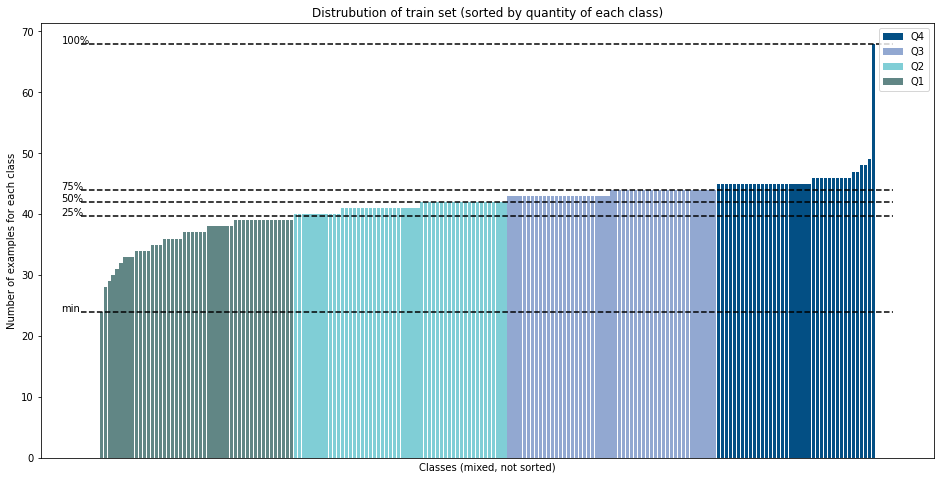

In [13]:
show_distribution(car_brands_distribution["train"], sort_by_values=True)

**Observations:**
* the number of classes in the Q1 group (min-25%) is highly diversified
* car classes from interquartile range (Q1, Q3] have a similar number of observations. A slight variation in the number of examples for each class can be observed
* classes that are in the top 25% of observations (in terms of quantity of observations), can be considered as not very differentiated as long as we exclude one class, which the number of observations reaches almost 70

**Hypoyhesis:**
* the model will be less able to recognize car brands, from groups where fewer photos are provided (lower score for classes from range min-Q1, the target group is exactly where the number of observation is less or equal to 37)
* the model will learn very well to recognize the class with the greatest number of observations (probably the best score)

Lines below are going to identify classes from hypothesis above:

In [14]:
def score_hypothesis(data, n_obs_threshold):
    best_score = data.nlargest(1)
    worst_scores = data[data <= 37]
    return best_score, worst_scores

In [15]:
h_best_score, h_worst_scores = score_hypothesis(car_brands_distribution["train"], 37)

<a name='5'></a>
## 5. Custom preprocessing and structurization of a dataset
Before data will be preprocessed, there are some assumptions about this project, that are needed to be mentioned:
* model is going to be trained on cropped version of an image. Every image is going to be cropped to its bounding box
* model is going to be tested on cropped version of an image, as well as original image (uncropped)

The Stanford University convention of training and test set will be remained, but original test set is going to be split into validation and test set, where each class is going to have roughly the same propotion ($\frac{\text{number of observation in each class}}{\text{set size}}$ roughly the same for val and test set)

What is more, folder structure has to be changed due to requirements of tensorflow  function *dataset_from_directory* (labels parameter do not work, confirmed by many users on stackoverflow). After performing a function below, new dataset directories structures should look as follows:


<div style="padding-left: 30px;">
    
    - dataset_rearranged/
        - cropped/
            - train/
                - 0/
                    *images for class 0*
                - ...
                - 195/
                    *images for class 195*
            - val/
                - 0/
                    *images for class 0*
                - ...
                - 195/
                    *images for class 195*    
            - test/
                - 0/
                    *images for class 0*
                - ...
                - 195/
                    *images for class 195*
        - original_resolution
            - test/
                - 0/
                    *images for class 0*
                - ...
                - 195/

</div>

In [16]:
class StructureImageFilesGetNames():
    def __init__(self, dataset_original_directory, annots_file_name):
        self.dataset_original_directory = dataset_original_directory
        self.annots_file_name = annots_file_name
        
        file_annots = scipy.io.loadmat(os.path.join(dataset_original_directory, annots_file_name))
        self.__file_annots = file_annots
        self.__annots = file_annots["annotations"]

    def get_class_names(self):
        return {i : self.__file_annots['class_names'][0][i][0] for i in range(196)}

    
    def __get_annots(self, i):
        return {"subpath" : self.__annots["relative_im_path"][0][i][0],
                "x1" : int(self.__annots["bbox_x1"][0][i]),
                "y1" : int(self.__annots["bbox_y1"][0][i]), 
                "x2" : int(self.__annots["bbox_x2"][0][i]),
                "y2": int(self.__annots["bbox_y2"][0][i]),
                "c" : int(self.__annots["class"][0][i] - 1),
                "set" : int(self.__annots["test"][0][i])}   

    def transform(self, new_location, original_test_distribution, validation_split_from_test=0.5, seed=42):
        threshold_val = (original_test_distribution * validation_split_from_test).astype(int)
        counter_val = pd.Series(data = 0, index=threshold_val.index)
        
        m = [x for x in range(len(self.__annots[0]))]   
        np.random.seed(seed)
        np.random.shuffle(m)
        for i in m:
            annots = self.__get_annots(i)
            temp_path = os.path.join(self.dataset_original_directory, annots["subpath"])
            
            img = plt.imread(temp_path, format="jpg")
            image_name = annots["subpath"][8:]
            image_class = annots["c"]
        
            if annots["set"] == 0:
                split = "train"
            elif annots["set"] == 1 and counter_val[image_class] < threshold_val[image_class]:
                counter_val[image_class] += 1
                split = "val"
            elif annots["set"] == 1 and counter_val[image_class] >= threshold_val[image_class]:
                split = "test"
                dir_path = os.path.join(new_location, "original_resolution", split, str(image_class))
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                plt.imsave(os.path.join(dir_path, image_name), img)
                
            dir_path = os.path.join(new_location, "cropped", split, str(image_class))
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            y1, y2, x1, x2 = annots["y1"], annots["y2"], annots["x1"], annots["x2"]
            plt.imsave(os.path.join(dir_path, image_name), img[y1 : y2, x1 : x2])
        print("Images successfully rearranged")

In [17]:
preprocess = StructureImageFilesGetNames(dataset_original_directory, annos_file_name)
preprocess.transform("dataset_rearranged", car_brands_distribution["test"])

In [18]:
class_names = preprocess.get_class_names()

<a name='6'></a>
## 6. Building a tensorflow dataset
Each CNN architecture of pre-trained models that will be used in this project, requires specific input image shape as well as some preprocessing. For example ResNet50 model requires input shape of (224, 224, 3). On the tensorflow website,there is a piece of information about what *preprocess_input* method does: "*The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling*". This preprocessing step is obligatory for an input, if we want the model to work well.

Let's define dataframe, that will gather variables which are necessary for building tensorflow dataset, as well as for model inplementation.

In [19]:
columns = ["image_shape", "module", "model_function"]
data = {"ResNet50": [(224, 224), tf.keras.applications.resnet50, tf.keras.applications.resnet50.ResNet50],
        "InceptionV3" : [(299, 299), tf.keras.applications.inception_v3, tf.keras.applications.inception_v3.InceptionV3],
        "MobileNetV2" : [(224, 224), tf.keras.applications.mobilenet_v2, tf.keras.applications.mobilenet_v2.MobileNetV2],
        "VGG19" : [(224, 224), tf.keras.applications.vgg19, tf.keras.applications.vgg19.VGG19]
       }
models_attributes = pd.DataFrame.from_dict(data, orient='index', columns=columns)
models_attributes

image_shape                                             module  \
ResNet50     (224, 224)  <module 'keras.api._v2.keras.applications.resn...   
InceptionV3  (299, 299)  <module 'keras.api._v2.keras.applications.ince...   
MobileNetV2  (224, 224)  <module 'keras.api._v2.keras.applications.mobi...   
VGG19        (224, 224)  <module 'keras.api._v2.keras.applications.vgg1...   

                                           model_function  
ResNet50        <function ResNet50 at 0x000001D60391E700>  
InceptionV3  <function InceptionV3 at 0x000001D6039053A0>  
MobileNetV2  <function MobileNetV2 at 0x000001D6039059D0>  
VGG19              <function VGG19 at 0x000001D60391EE50>

In [20]:
def make_tensorflow_dataset(dataset_directory, resolution_directory, set_directory, img_shape, module, batch_size=32):
    def preprocess(image, label):
            image = tf.cast(module.preprocess_input(image), tf.float32)
            return image, label
    path = os.path.join(dataset_directory, resolution_directory, set_directory)
    
    dataset = tf.keras.utils.image_dataset_from_directory(path, batch_size=batch_size, image_size=img_shape)
    return dataset.map(preprocess)

In [21]:
datasets_tf = pd.DataFrame(columns=["train", "val", "test", "test_original"])
for name, attributes in models_attributes.iterrows():
    print("-------------------------------------------")
    print(f"Now, creating a dataset for {name} model")
    train = make_tensorflow_dataset("dataset_rearranged", "cropped", "train", attributes["image_shape"],
                                    attributes["module"])
    val = make_tensorflow_dataset("dataset_rearranged", "cropped", "val", attributes["image_shape"], attributes["module"])
    test = make_tensorflow_dataset("dataset_rearranged", "cropped", "test", attributes["image_shape"],
                                   attributes["module"], batch_size=1)
    test_original = make_tensorflow_dataset("dataset_rearranged", "original_resolution", "test", attributes["image_shape"],
                                            attributes["module"], batch_size=1)
    
    
    datasets_tf.loc[name] = train, val, test, test_original
    print("-------------------------------------------")

-------------------------------------------
Now, creating a dataset for ResNet50 model
Found 8144 files belonging to 196 classes.
Found 3977 files belonging to 196 classes.
Found 4064 files belonging to 196 classes.
Found 4064 files belonging to 196 classes.
-------------------------------------------
-------------------------------------------
Now, creating a dataset for InceptionV3 model
Found 8144 files belonging to 196 classes.
Found 3977 files belonging to 196 classes.
Found 4064 files belonging to 196 classes.
Found 4064 files belonging to 196 classes.
-------------------------------------------
-------------------------------------------
Now, creating a dataset for MobileNetV2 model
Found 8144 files belonging to 196 classes.
Found 3977 files belonging to 196 classes.
Found 4064 files belonging to 196 classes.
Found 4064 files belonging to 196 classes.
-------------------------------------------
-------------------------------------------
Now, creating a dataset for VGG19 model
F

<a name='7'></a>
## 7. Training multiple models
The next step is to define models architectures. Each of used models:
1. will take an image of required shape as an input (in fact tensorflow dataset with preprocessed images from previous section)
2. Then, the image will go through base model (ResNet50, InceptionV3, MobileNetV2 or VGG19) and output some three dimensional object
3. In the next step, the GloalAveragePooling2D will be used to summarize the information in each channel of this 3D object. What is more, this action will also transform 3D object do Dense layer (number of neurons = length of third dimension)
4. Afterwards, Fully-Connected (Dense) layers will be applied. The number of layers and the number of neurons in each of them will be defined by an user in a hidden_top hyperparameter
5. Last hidden Dense layer will be forward propagated to another Dense layer (196 neuros) with the usage of softmax activation function (this is the ouput layer)

**Note:**
* base model will not be trained (at leat for now)
* dropout layer (which I did not mention) will also be used to avoid overfitting
* the output layer has 196 neurons, because in this task, there are 196 unique car brands
* softmax activation function is used, because it allows to see probability estimation for each class. Those probabilities sum up to 1 and the class with the highest probability value is the one which model predicts. What is more, softmax activation probabilities are interrelated (which is the case in this project problem - there can be only one brand of a car)

With that being said, let's define model function.

In [22]:
def model(input_shape, base_model, hidden_top, dropout, learning_rate=0.0001):
    input_shape = input_shape + (3, )
    inputs = tf.keras.Input(shape = input_shape)
    
    base = base_model(input_shape=input_shape, include_top=False, weights="imagenet")
    base.trainable = False

    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    for i in range(len(hidden_top)):
        x = tf.keras.layers.Dense(hidden_top[i], activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(196, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
    
    return model

Let's also define: 
* model_checkpoint function which will save the best model weights
* tensorflow early stoping object (which will stop the training if model does not improve for given number of iterations)


In [23]:
def model_checkpoint(name):
    filepath = "weights/" + name + ".h5"
    return tf.keras.callbacks.ModelCheckpoint(filepath, monitor = "val_sparse_categorical_accuracy", verbose=1,
                                              save_best_only=True, save_weights_only=True, mode="max")

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)

And the last preparation step, let's create directiories to store model weights and training history.

In [25]:
if not os.path.exists("weights"):
    os.mkdir("weights")
    print("'weights' directory created")
    
if not os.path.exists("training_history"):
    os.mkdir("training_history")
    print("'training_history' directory created")

<a name='7A'></a>
### A. ResNet50 

In [26]:
ds_train_resnet50 = datasets_tf.loc["ResNet50"]["train"]
ds_val_resnet50 = datasets_tf.loc["ResNet50"]["val"]
checkpoint_resnet50 = model_checkpoint("resnet50")

In [27]:
resnet50_model = model(models_attributes.loc["ResNet50"]["image_shape"],
                       models_attributes.loc["ResNet50"]["model_function"],
                       hidden_top=[1024, 1024],
                       dropout=0.3)
resnet50_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

<span style="color:red">**Note for grader:** The cell bellow fits a model and saves the best weights in given localization from *model_checkpoint* function. It also saves training history. Running this cell might take some time. Weight obtained during training as well as training history, which are provided in this repo, will be loaded later </span>

In [28]:
# resnet50_history = resnet50_model.fit(ds_train_resnet50, validation_data=ds_val_resnet50, epochs=200,
#                                       callbacks=[early_stopping, checkpoint_resnet50])

# with open("training_history/resnet50.pickle", "wb") as f:
#     pickle.dump(resnet50_history.history, f)

Epoch 1/200
255/255 [==============================] - ETA: 0s - loss: 5.2552 - sparse_categorical_accuracy: 0.0140
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.08071, saving model to weights\resnet50.h5
255/255 [==============================] - 774s 3s/step - loss: 5.2552 - sparse_categorical_accuracy: 0.0140 - val_loss: 4.8263 - val_sparse_categorical_accuracy: 0.0807
Epoch 2/200
255/255 [==============================] - ETA: 0s - loss: 4.6655 - sparse_categorical_accuracy: 0.0562
Epoch 2: val_sparse_categorical_accuracy improved from 0.08071 to 0.16671, saving model to weights\resnet50.h5
255/255 [==============================] - 790s 3s/step - loss: 4.6655 - sparse_categorical_accuracy: 0.0562 - val_loss: 4.0523 - val_sparse_categorical_accuracy: 0.1667
Epoch 3/200
255/255 [==============================] - ETA: 0s - loss: 4.0700 - sparse_categorical_accuracy: 0.1163
Epoch 3: val_sparse_categorical_accuracy improved from 0.16671 to 0.23887, saving model to we

Epoch 22/200
255/255 [==============================] - ETA: 0s - loss: 1.0697 - sparse_categorical_accuracy: 0.6928
Epoch 22: val_sparse_categorical_accuracy improved from 0.62333 to 0.62786, saving model to weights\resnet50.h5
255/255 [==============================] - 790s 3s/step - loss: 1.0697 - sparse_categorical_accuracy: 0.6928 - val_loss: 1.3937 - val_sparse_categorical_accuracy: 0.6279
Epoch 23/200
255/255 [==============================] - ETA: 0s - loss: 1.0157 - sparse_categorical_accuracy: 0.7053
Epoch 23: val_sparse_categorical_accuracy improved from 0.62786 to 0.62987, saving model to weights\resnet50.h5
255/255 [==============================] - 790s 3s/step - loss: 1.0157 - sparse_categorical_accuracy: 0.7053 - val_loss: 1.3704 - val_sparse_categorical_accuracy: 0.6299
Epoch 24/200
255/255 [==============================] - ETA: 0s - loss: 0.9552 - sparse_categorical_accuracy: 0.7232
Epoch 24: val_sparse_categorical_accuracy improved from 0.62987 to 0.63490, saving mo

Epoch 44/200
255/255 [==============================] - ETA: 0s - loss: 0.4163 - sparse_categorical_accuracy: 0.8728
Epoch 44: val_sparse_categorical_accuracy did not improve from 0.67589
255/255 [==============================] - 792s 3s/step - loss: 0.4163 - sparse_categorical_accuracy: 0.8728 - val_loss: 1.2254 - val_sparse_categorical_accuracy: 0.6756
Epoch 45/200
255/255 [==============================] - ETA: 0s - loss: 0.3994 - sparse_categorical_accuracy: 0.8755
Epoch 45: val_sparse_categorical_accuracy did not improve from 0.67589
255/255 [==============================] - 792s 3s/step - loss: 0.3994 - sparse_categorical_accuracy: 0.8755 - val_loss: 1.2377 - val_sparse_categorical_accuracy: 0.6683
Epoch 46/200
255/255 [==============================] - ETA: 0s - loss: 0.3894 - sparse_categorical_accuracy: 0.8814
Epoch 46: val_sparse_categorical_accuracy did not improve from 0.67589
255/255 [==============================] - 795s 3s/step - loss: 0.3894 - sparse_categorical_accu

Epoch 67/200
255/255 [==============================] - ETA: 0s - loss: 0.2259 - sparse_categorical_accuracy: 0.9288
Epoch 67: val_sparse_categorical_accuracy improved from 0.68444 to 0.68594, saving model to weights\resnet50.h5
255/255 [==============================] - 790s 3s/step - loss: 0.2259 - sparse_categorical_accuracy: 0.9288 - val_loss: 1.2260 - val_sparse_categorical_accuracy: 0.6859


<a name='7B'></a>
### B. InceptionV3

In [28]:
ds_train_inception_v3 = datasets_tf.loc["InceptionV3"]["train"]
ds_val_inception_v3 = datasets_tf.loc["InceptionV3"]["val"]
checkpoint_inception_v3 = model_checkpoint("inception_v3")

In [29]:
inception_v3_model = model(models_attributes.loc["InceptionV3"]["image_shape"],
                           models_attributes.loc["InceptionV3"]["model_function"],
                           hidden_top=[1024, 1024],
                           dropout=0.3)
inception_v3_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                           

<span style="color:red">**Note for grader:** The cell bellow fits a model and saves the best weights in given localization from *model_checkpoint* function. It also saves training history. Running this cell might take some time. Weight obtained during training as well as training history, which are provided in this repo, will be loaded later </span>

In [31]:
# inception_v3_history = inception_v3_model.fit(ds_train_inception_v3, validation_data=ds_val_inception_v3, epochs=200,
#                                               callbacks=[early_stopping, checkpoint_inception_v3])

# with open("training_history/inception_v3.pickle", "wb") as f:
#     pickle.dump(inception_v3_history.history, f)

Epoch 1/200
255/255 [==============================] - ETA: 0s - loss: 5.0744 - sparse_categorical_accuracy: 0.0242
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.07292, saving model to weights\inception_v3.h5
255/255 [==============================] - 937s 4s/step - loss: 5.0744 - sparse_categorical_accuracy: 0.0242 - val_loss: 4.4542 - val_sparse_categorical_accuracy: 0.0729
Epoch 2/200
255/255 [==============================] - ETA: 0s - loss: 4.2808 - sparse_categorical_accuracy: 0.0699
Epoch 2: val_sparse_categorical_accuracy improved from 0.07292 to 0.14408, saving model to weights\inception_v3.h5
255/255 [==============================] - 935s 4s/step - loss: 4.2808 - sparse_categorical_accuracy: 0.0699 - val_loss: 3.7137 - val_sparse_categorical_accuracy: 0.1441
Epoch 3/200
255/255 [==============================] - ETA: 0s - loss: 3.7910 - sparse_categorical_accuracy: 0.1055
Epoch 3: val_sparse_categorical_accuracy improved from 0.14408 to 0.20191, saving mod

255/255 [==============================] - 933s 4s/step - loss: 1.7200 - sparse_categorical_accuracy: 0.5206 - val_loss: 1.9061 - val_sparse_categorical_accuracy: 0.4833
Epoch 22/200
255/255 [==============================] - ETA: 0s - loss: 1.6752 - sparse_categorical_accuracy: 0.5263
Epoch 22: val_sparse_categorical_accuracy improved from 0.48328 to 0.48780, saving model to weights\inception_v3.h5
255/255 [==============================] - 932s 4s/step - loss: 1.6752 - sparse_categorical_accuracy: 0.5263 - val_loss: 1.8851 - val_sparse_categorical_accuracy: 0.4878
Epoch 23/200
255/255 [==============================] - ETA: 0s - loss: 1.6164 - sparse_categorical_accuracy: 0.5449
Epoch 23: val_sparse_categorical_accuracy improved from 0.48780 to 0.49585, saving model to weights\inception_v3.h5
255/255 [==============================] - 934s 4s/step - loss: 1.6164 - sparse_categorical_accuracy: 0.5449 - val_loss: 1.8637 - val_sparse_categorical_accuracy: 0.4959
Epoch 24/200
255/255 [==

255/255 [==============================] - 940s 4s/step - loss: 1.0213 - sparse_categorical_accuracy: 0.6952 - val_loss: 1.6144 - val_sparse_categorical_accuracy: 0.5549
Epoch 43/200
255/255 [==============================] - ETA: 0s - loss: 0.9729 - sparse_categorical_accuracy: 0.7073
Epoch 43: val_sparse_categorical_accuracy improved from 0.55871 to 0.55947, saving model to weights\inception_v3.h5
255/255 [==============================] - 943s 4s/step - loss: 0.9729 - sparse_categorical_accuracy: 0.7073 - val_loss: 1.5957 - val_sparse_categorical_accuracy: 0.5595
Epoch 44/200
255/255 [==============================] - ETA: 0s - loss: 0.9370 - sparse_categorical_accuracy: 0.7222
Epoch 44: val_sparse_categorical_accuracy improved from 0.55947 to 0.56651, saving model to weights\inception_v3.h5
255/255 [==============================] - 939s 4s/step - loss: 0.9370 - sparse_categorical_accuracy: 0.7222 - val_loss: 1.5997 - val_sparse_categorical_accuracy: 0.5665
Epoch 45/200
255/255 [==

Epoch 65/200
255/255 [==============================] - ETA: 0s - loss: 0.6190 - sparse_categorical_accuracy: 0.8148
Epoch 65: val_sparse_categorical_accuracy improved from 0.58109 to 0.58285, saving model to weights\inception_v3.h5
255/255 [==============================] - 940s 4s/step - loss: 0.6190 - sparse_categorical_accuracy: 0.8148 - val_loss: 1.5625 - val_sparse_categorical_accuracy: 0.5829
Epoch 66/200
255/255 [==============================] - ETA: 0s - loss: 0.6056 - sparse_categorical_accuracy: 0.8130
Epoch 66: val_sparse_categorical_accuracy did not improve from 0.58285
255/255 [==============================] - 937s 4s/step - loss: 0.6056 - sparse_categorical_accuracy: 0.8130 - val_loss: 1.5533 - val_sparse_categorical_accuracy: 0.5786
Epoch 67/200
255/255 [==============================] - ETA: 0s - loss: 0.5870 - sparse_categorical_accuracy: 0.8196
Epoch 67: val_sparse_categorical_accuracy did not improve from 0.58285
255/255 [==============================] - 938s 4s/

<a name='7C'></a>
### C. MobileNetV2

In [30]:
ds_train_mobilenet_v2 = datasets_tf.loc["MobileNetV2"]["train"]
ds_val_mobilenet_v2 = datasets_tf.loc["MobileNetV2"]["val"]
checkpoint_mobilenet_v2 = model_checkpoint("mobilenetv2")

In [31]:
mobilenet_v2_model = model(models_attributes.loc["MobileNetV2"]["image_shape"],
                           models_attributes.loc["MobileNetV2"]["model_function"],
                           hidden_top=[512, 512],
                           dropout=0.3)
mobilenet_v2_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0   

<span style="color:red">**Note for grader:** The cell bellow fits a model and saves the best weights in given localization from *model_checkpoint* function. It also saves training history. Running this cell might take some time. Weight obtained during training as well as training history, which are provided in this repo, will be loaded later </span>

In [34]:
# mobilenet_v2_history = mobilenet_v2_model.fit(ds_train_mobilenet_v2, validation_data=ds_val_mobilenet_v2, epochs=200,
#                                               callbacks=[early_stopping, checkpoint_mobilenet_v2])

# with open("training_history/mobilenet_v2.pickle", "wb") as f:
#     pickle.dump(mobilenet_v2_history.history, f)

Epoch 1/200
255/255 [==============================] - ETA: 0s - loss: 5.2883 - sparse_categorical_accuracy: 0.0103
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.03596, saving model to weights\mobilenetv2.h5
255/255 [==============================] - 197s 761ms/step - loss: 5.2883 - sparse_categorical_accuracy: 0.0103 - val_loss: 5.0618 - val_sparse_categorical_accuracy: 0.0360
Epoch 2/200
255/255 [==============================] - ETA: 0s - loss: 4.9506 - sparse_categorical_accuracy: 0.0287
Epoch 2: val_sparse_categorical_accuracy improved from 0.03596 to 0.07317, saving model to weights\mobilenetv2.h5
255/255 [==============================] - 193s 758ms/step - loss: 4.9506 - sparse_categorical_accuracy: 0.0287 - val_loss: 4.5650 - val_sparse_categorical_accuracy: 0.0732
Epoch 3/200
255/255 [==============================] - ETA: 0s - loss: 4.5378 - sparse_categorical_accuracy: 0.0562
Epoch 3: val_sparse_categorical_accuracy improved from 0.07317 to 0.12623, saving

255/255 [==============================] - 194s 762ms/step - loss: 1.2756 - sparse_categorical_accuracy: 0.6321 - val_loss: 1.5680 - val_sparse_categorical_accuracy: 0.5738
Epoch 42/200
255/255 [==============================] - ETA: 0s - loss: 1.2387 - sparse_categorical_accuracy: 0.6469
Epoch 42: val_sparse_categorical_accuracy improved from 0.57380 to 0.57531, saving model to weights\mobilenetv2.h5
255/255 [==============================] - 194s 763ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.6469 - val_loss: 1.5603 - val_sparse_categorical_accuracy: 0.5753
Epoch 43/200
255/255 [==============================] - ETA: 0s - loss: 1.2120 - sparse_categorical_accuracy: 0.6536
Epoch 43: val_sparse_categorical_accuracy improved from 0.57531 to 0.58260, saving model to weights\mobilenetv2.h5
255/255 [==============================] - 194s 761ms/step - loss: 1.2120 - sparse_categorical_accuracy: 0.6536 - val_loss: 1.5520 - val_sparse_categorical_accuracy: 0.5826
Epoch 44/200
255/

255/255 [==============================] - ETA: 0s - loss: 0.6257 - sparse_categorical_accuracy: 0.8070
Epoch 85: val_sparse_categorical_accuracy did not improve from 0.61881
255/255 [==============================] - 194s 759ms/step - loss: 0.6257 - sparse_categorical_accuracy: 0.8070 - val_loss: 1.4168 - val_sparse_categorical_accuracy: 0.6060
Epoch 86/200
255/255 [==============================] - ETA: 0s - loss: 0.6268 - sparse_categorical_accuracy: 0.8102
Epoch 86: val_sparse_categorical_accuracy did not improve from 0.61881
255/255 [==============================] - 193s 759ms/step - loss: 0.6268 - sparse_categorical_accuracy: 0.8102 - val_loss: 1.4129 - val_sparse_categorical_accuracy: 0.6128
Epoch 87/200
255/255 [==============================] - ETA: 0s - loss: 0.6012 - sparse_categorical_accuracy: 0.8180
Epoch 87: val_sparse_categorical_accuracy did not improve from 0.61881
255/255 [==============================] - 193s 759ms/step - loss: 0.6012 - sparse_categorical_accuracy

255/255 [==============================] - 194s 760ms/step - loss: 0.4577 - sparse_categorical_accuracy: 0.8601 - val_loss: 1.4154 - val_sparse_categorical_accuracy: 0.6191
Epoch 108/200
255/255 [==============================] - ETA: 0s - loss: 0.4587 - sparse_categorical_accuracy: 0.8628
Epoch 108: val_sparse_categorical_accuracy did not improve from 0.62233
255/255 [==============================] - 193s 758ms/step - loss: 0.4587 - sparse_categorical_accuracy: 0.8628 - val_loss: 1.4055 - val_sparse_categorical_accuracy: 0.6198
Epoch 109/200
255/255 [==============================] - ETA: 0s - loss: 0.4473 - sparse_categorical_accuracy: 0.8665
Epoch 109: val_sparse_categorical_accuracy did not improve from 0.62233
255/255 [==============================] - 194s 760ms/step - loss: 0.4473 - sparse_categorical_accuracy: 0.8665 - val_loss: 1.3991 - val_sparse_categorical_accuracy: 0.6143
Epoch 110/200
255/255 [==============================] - ETA: 0s - loss: 0.4401 - sparse_categorical_

<a name='7D'></a>
### D. VGG19

In [32]:
ds_train_vgg19 = datasets_tf.loc["VGG19"]["train"]
ds_val_vgg19 = datasets_tf.loc["VGG19"]["val"]
checkpoint_vgg19 = model_checkpoint("vgg19")

In [33]:
vgg19_model = model(models_attributes.loc["VGG19"]["image_shape"],
                    models_attributes.loc["VGG19"]["model_function"],
                    hidden_top=[512, 512],
                    dropout=0.2,
                    learning_rate=0.001)
vgg19_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                           

<span style="color:red">**Note for grader:** The cell bellow fits a model and saves the best weights in given localization from *model_checkpoint* function. It also saves training history. Running this cell might take some time. Weight obtained during training as well as training history, which are provided in this repo, will be loaded later </span>

<span style="color:red">**Important:** Multiple models, were trained on different machines (laptop and PC), so in case of VGG19 there is no output cell in this notebook, but there is a screenshot of this output cell from different machine </span>

In [ ]:
# vgg19_history = vgg19_model.fit(ds_train_vgg19, validation_data=ds_val_vgg19, epochs=100,
#                                 callbacks=[early_stopping, checkpoint_vgg19])

# with open("training_history/vgg19.pickle", "wb") as f:
#     pickle.dump(vgg19_history.history, f)

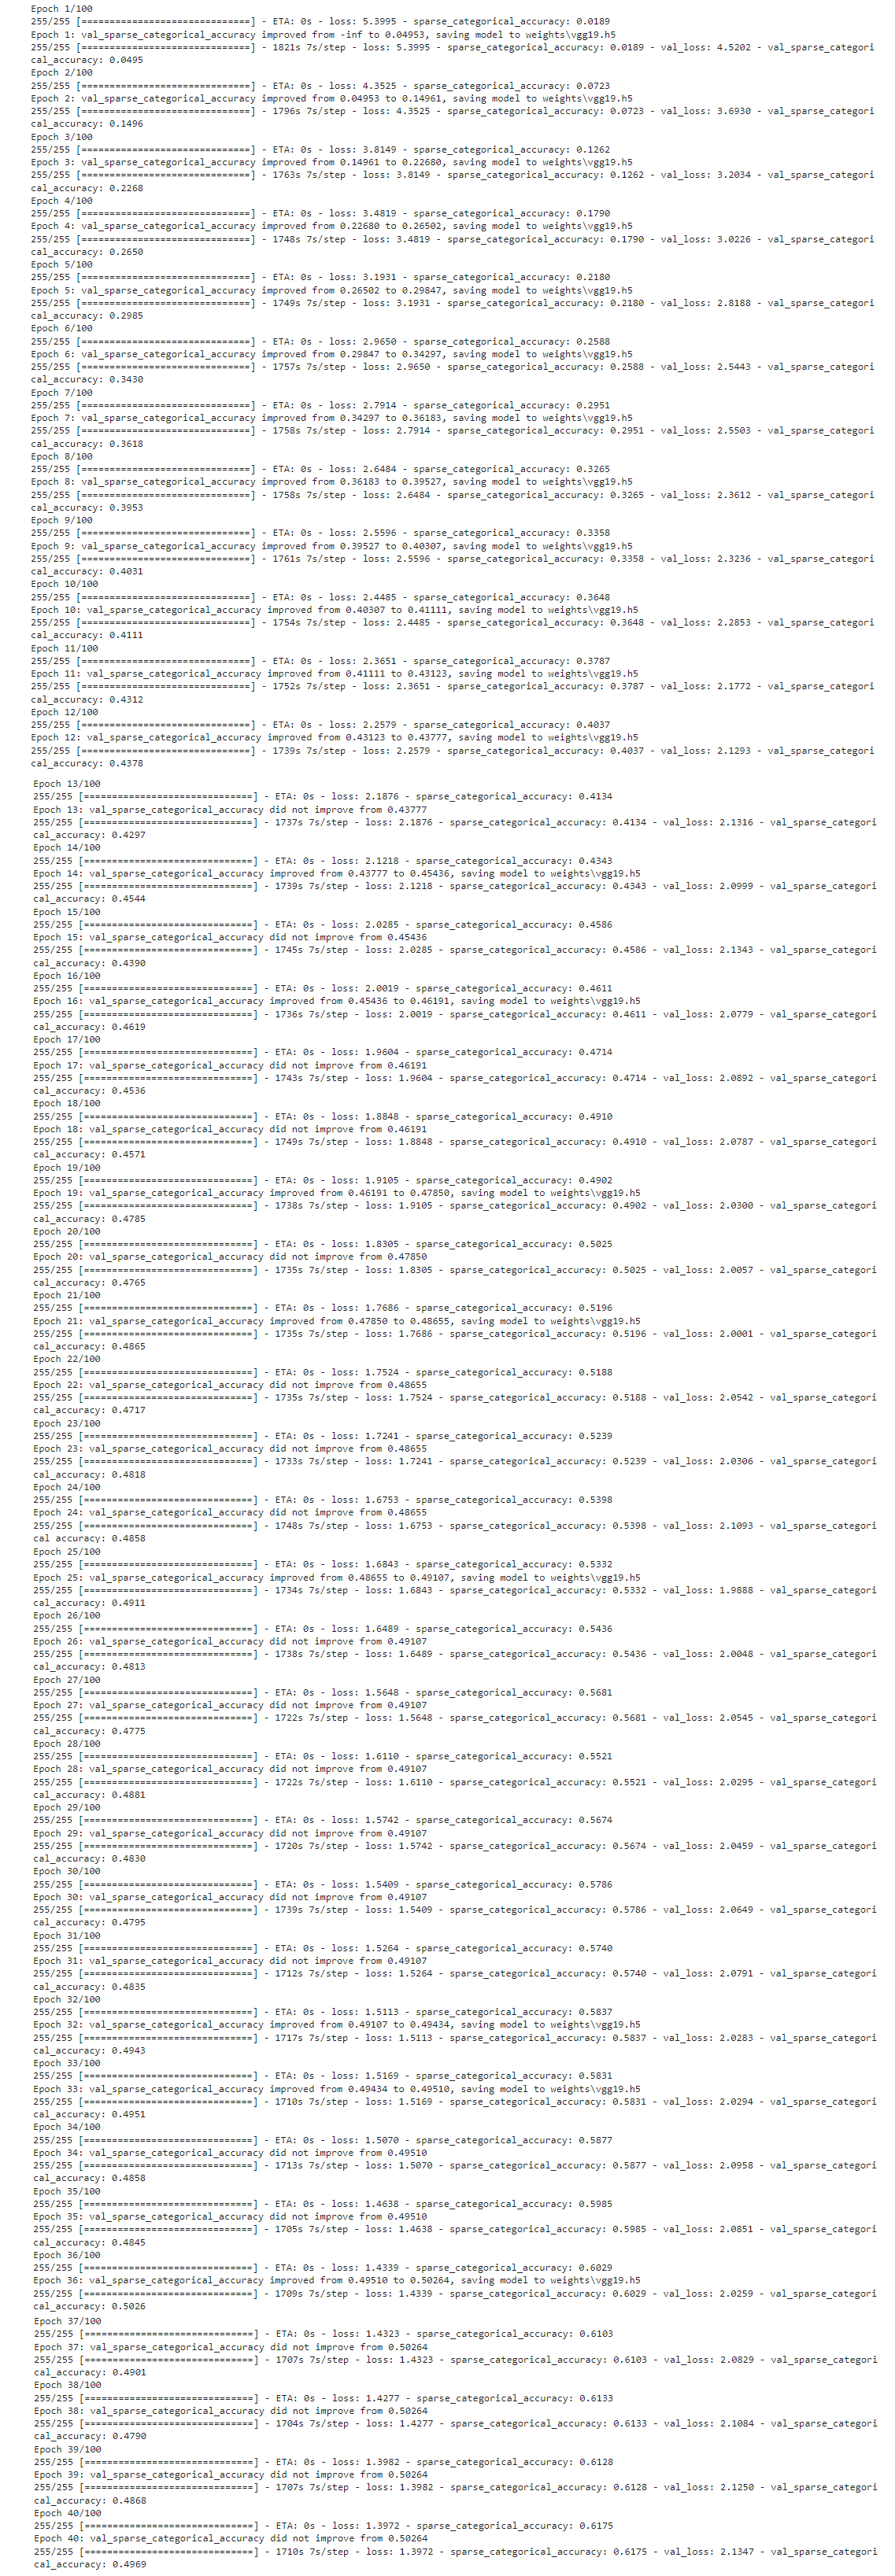

<a name='8'></a>
## 8. Learning process analysys
First of all, let's define global variable *names* that will be used multiple times in this section and later on. Next cell, will plot training histories for multiple models.

In [34]:
names = ["ResNet50", "InceptionV3", "MobileNetV2", "VGG19"]

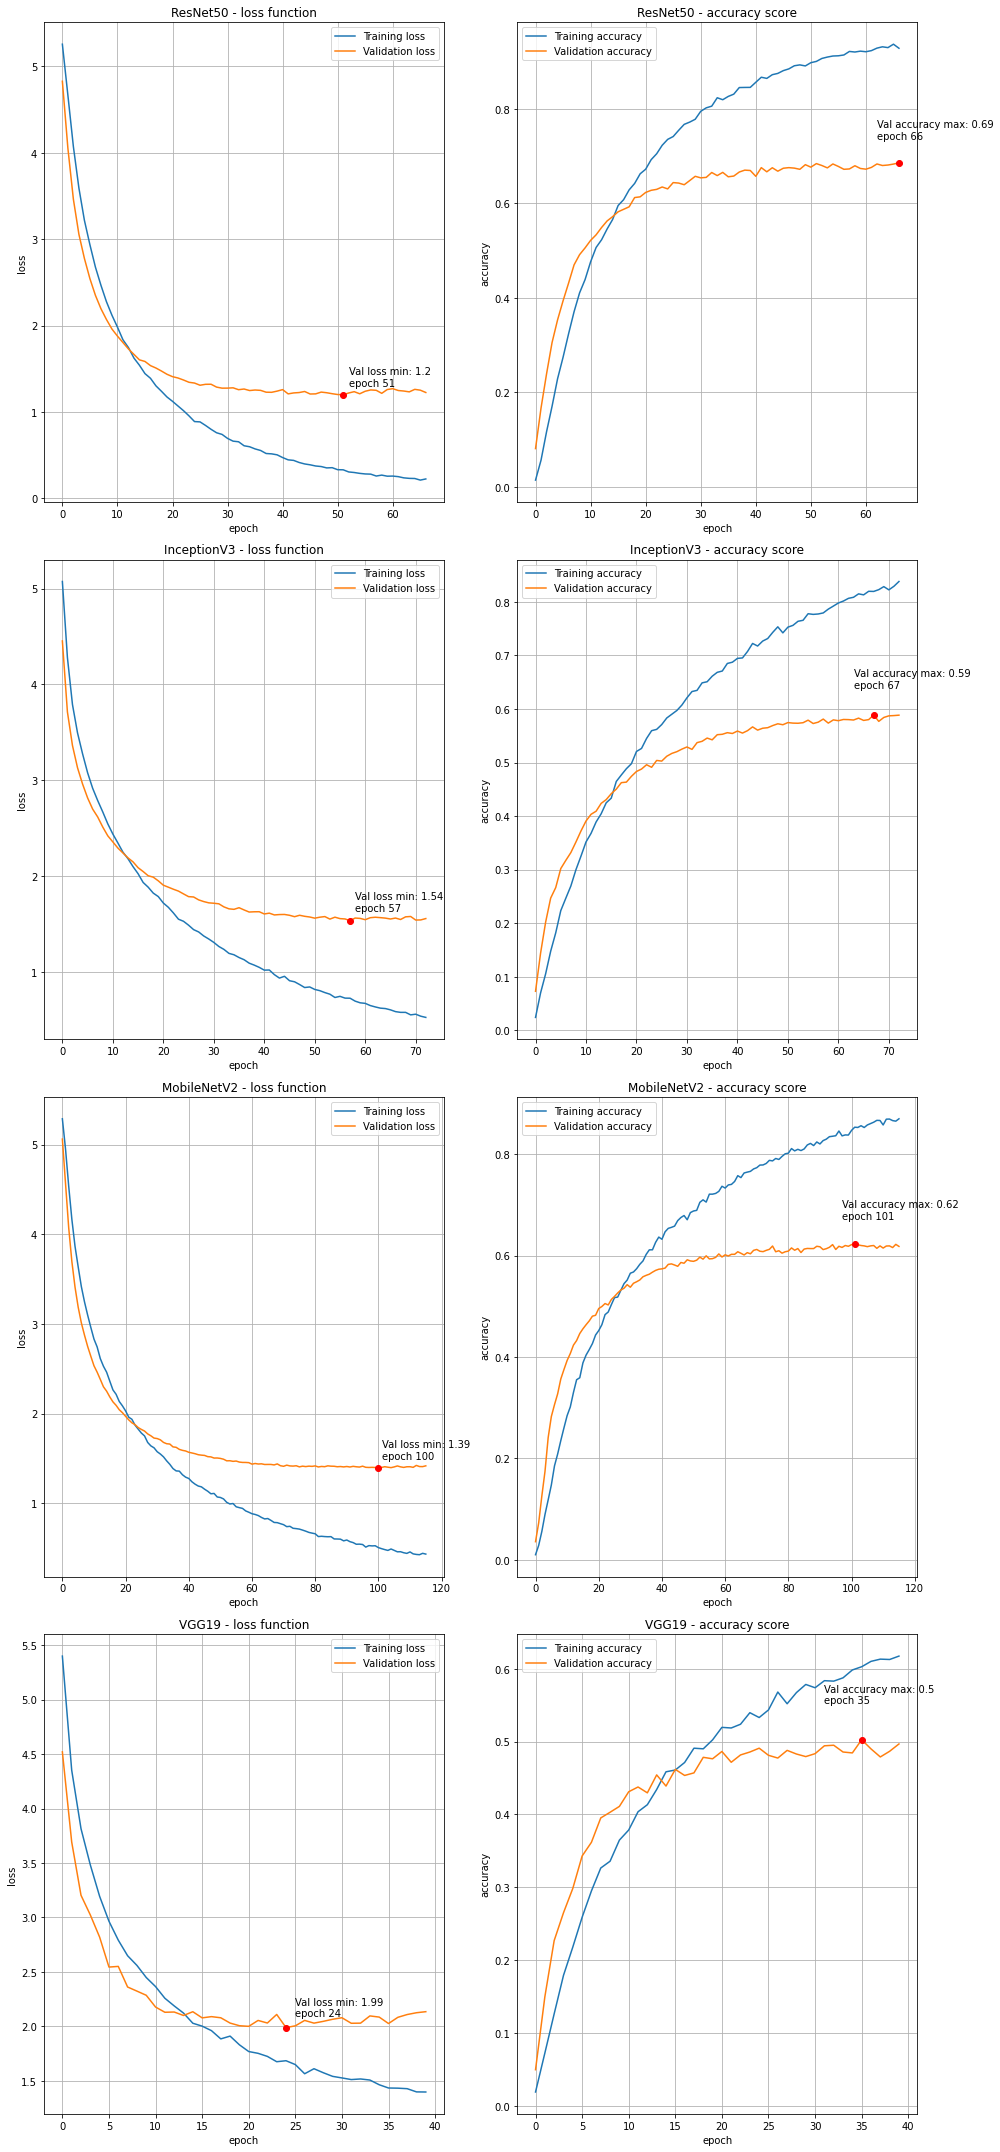

Scores obtained during training for train and val datasets:

             training validation
ResNet50     0.928782   0.685944
InceptionV3  0.819376   0.588635
MobileNetV2  0.853021   0.622328
VGG19        0.602898    0.50264


In [35]:
histories = ['resnet50.pickle',  'inception_v3.pickle', 'mobilenet_v2.pickle', 'vgg19.pickle']
training_scores = pd.DataFrame(index=names, columns=["training", "validation"])

plt.figure(figsize=(14, 30))
for i, (name, hist_file) in enumerate(zip(names, histories)):
    path = os.path.join("training_history", hist_file)
    with open(path, "rb") as model_history:
        temp_history = pickle.load(model_history)
    loss = temp_history["loss"]
    val_loss = temp_history["val_loss"]
    sparse_categorical_accuracy = temp_history["sparse_categorical_accuracy"]
    val_sparse_categorical_accuracy = temp_history["val_sparse_categorical_accuracy"]
    min_val_loss, val_loss_idx = np.min(val_loss), np.argmin(val_loss)
    max_val_acc, val_acc_idx = np.max(val_sparse_categorical_accuracy), np.argmax(val_sparse_categorical_accuracy)
    training_scores.loc[name] = sparse_categorical_accuracy[val_acc_idx], val_sparse_categorical_accuracy[val_acc_idx]
    
    plt.subplot(len(histories), 2, 2 * i + 1)
    plt.plot(loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.plot(val_loss_idx, min_val_loss, marker="o", color="r")
    plt.annotate(f"Val loss min: {np.round(min_val_loss, 2)}\nepoch {val_loss_idx}",
                 (val_loss_idx + 1, min_val_loss + 0.1))
    plt.title(f"{name} - loss function")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    
    plt.subplot(len(histories), 2, 2 * i + 2)
    plt.plot(sparse_categorical_accuracy, label="Training accuracy")
    plt.plot(val_sparse_categorical_accuracy, label="Validation accuracy")
    plt.plot(val_acc_idx, max_val_acc, marker="o", color="r")
    plt.annotate(f"Val accuracy max: {np.round(max_val_acc, 2)}\nepoch {val_acc_idx}",
                 (val_acc_idx - 4, max_val_acc + 0.05))
    plt.title(f"{name} - accuracy score")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.tight_layout()
    plt.legend()
    plt.grid()
plt.show()

print("Scores obtained during training for train and val datasets:\n")
print(training_scores)

As shown on graphs above, the best categorical accuracy score was obtained for ResNet50 model. In case of this model, the minumim loss function value was reached after 51 epochs. The patience parameter in early stopping was set to 15 epochs, whereas monitor was set to *val_loss*. On the other hand, the monitor parameter in *checkpoint* was set to "val_sparse_categorical_accuracy". Why monitors are not coherent (both set to min loss or max metric's score)?

The clue of setting early stopping monitor to *val_loss* and checkpoint monitor to *val_sparse_categorical_accuracy* is as follows:
- after finding local minimum, the loss function is going to oscilate around local minimum
- while oscilating around local minimum, save weights only for this epoch, which give the best performance on validation set (adjust to val set)

This action enables to take some extra advantages in sense of model performance, while *patiently* waiting to satisfy early stopping requirements.

The same analysys applies to other models as well.

**Accuracy on a trainig set:**

If we take a look at accuracy score obtained during training, we can see that:
- ResNet50 and MobileNetV2 have the best accuracy (about 92% and 85%) on training set
- InceptionV3 has a preety solid perforamnce on training set - 81%% accuracy
- the worst one is VGG19 model. Only 60% accuracy

**Accuracy on a validation set:**

The order of performance is the same as for training set accuracy. There is one observation that can be made:
- for ResNet50, InceptionV3 and MobileNetV2 there is a huge gap in accuracy between training and validation set (about 20-25% less for each of them)
- VGG19 model performance on training a validation set differs only by 10%, but in compare to other models, its accuracy is not that good

**Summary:**
- none of the models overfits the training data, but every of them have better accuracy on training set than on validation set
- ResNet50 model and MobileNetV2 have pretty solid accuracy (about 90%) on training data
- the best generalization outside of known images was obtained for ResNet50 model and MobileNetV2


<a name='9'></a>
## 9. Performance on test set
In this section, every model performance will be examined on cropped test set, as well as on test set with original image resolution.

Firsty, let's upload models best weights:

In [36]:
resnet50_model.load_weights("weights/resnet50.h5")
inception_v3_model.load_weights("weights/inception_v3.h5")
mobilenet_v2_model.load_weights("weights/mobilenetv2.h5")
vgg19_model.load_weights("weights/vgg19.h5")

<a name='9A'></a>
### A. Total accuracy scores

In [37]:
models = [resnet50_model, inception_v3_model, mobilenet_v2_model, vgg19_model]
accuracy_scores = pd.DataFrame(index=names, columns = ["test_cropped", "test_original"])
for name, model in zip(names, models):
    print("--------------------------------------")
    print(f"Calculating accuracy for {name} model")
    ds_test_cropped = datasets_tf.loc[name]["test"]
    ds_test_original = datasets_tf.loc[name]["test_original"]
    accuracy_scores.loc[name]["test_cropped"] = model.evaluate(ds_test_cropped)[1]
    accuracy_scores.loc[name]["test_original"] = model.evaluate(ds_test_original)[1]
    print("--------------------------------------")
accuracy_scores

--------------------------------------
Calculating accuracy for ResNet50 model
4064/4064 [==============================] - 502s 123ms/step - loss: 2.9789 - sparse_categorical_accuracy: 0.4210
--------------------------------------
--------------------------------------
Calculating accuracy for InceptionV3 model
4064/4064 [==============================] - 547s 134ms/step - loss: 2.4527 - sparse_categorical_accuracy: 0.4235
--------------------------------------
--------------------------------------
Calculating accuracy for MobileNetV2 model
4064/4064 [==============================] - 163s 40ms/step - loss: 2.8620 - sparse_categorical_accuracy: 0.3848
--------------------------------------
--------------------------------------
Calculating accuracy for VGG19 model
4064/4064 [==============================] - 698s 172ms/step - loss: 3.5872 - sparse_categorical_accuracy: 0.2574
--------------------------------------


test_cropped test_original
ResNet50        0.698081      0.421014
InceptionV3      0.60187      0.423474
MobileNetV2     0.625738      0.384843
VGG19           0.502215      0.257382

In the dataframe above, we can see accuracy score for each model on test cropped images, as well as on test images with orginal resolution.

**Overall analysis of performance on test sets:**

Taking into consideration that accuracy of human car expert will probably be equal to 100%, the model seems not to have satifying performance. On the other hand, random guess in this case is equal to nearly 0.5% (1 divided by 196). Overall, the best accuracy is equal to nearly 70% on **test cropped images**. This accuraccy is much more better than random guess, but is not that good as human expert accuracy.

On test sets with **orginal aspect ratio**, in the best case, a model is able to correctly classify about 2/5 of all examples. It is pretty good performance, taking into consideration the fact, that models was trained on images with different pixels distribution (cropped images vs original resolution images).


What is more, during evaluation of each model, we can see how fast each image is classified. With respect to this satisfying metric, the classification speed scores are as follows:
1. MobileNetV2
2. InceptionV3
3. ResNet50
4. VGG19

This scores are important in this project, because later on, 2 models will be fine-tuned:
- the one with the best accuracy (ResNet50)
- the fastest one (MobileNetV2)

<a name='9B'></a>
### B. Comparison of accuracy scores for the best and the worst categories (each one model vs rest)

Before drawing a plots, let's calculate accuracy for each class in every model on *test cropped set* as well as on *test orginal resolution set* and save result into a file.

In [38]:
def multiclass_accuracy(dataset, model):
    labels = pd.DataFrame([[int(y), np.argmax(model.predict(x))] for x, y in dataset],
                          columns = ["actual", "prediction"])
    categorical_accuracy = sklearn.metrics.confusion_matrix(labels["actual"], labels["prediction"],
                                                            normalize="true").diagonal()
    return categorical_accuracy

<span style="color:red">**Note for grader:** The cell below calculates accuracy for each class for every model on two test sets (cropped and original resolution). Running the code below might take some time. Instead of waiting for results, you can always load them from a file (the next cell), because they were calculated earlier and saved. </span>

In [45]:
# classes_accuracy_crop = pd.DataFrame(index=class_names.values())
# classes_accuracy_original = pd.DataFrame(index=class_names.values())

# for name, model in zip(names, models):
#     classes_accuracy_crop[name] = multiclass_accuracy(datasets_tf.loc[name]["test"], model)
#     classes_accuracy_original[name] = multiclass_accuracy(datasets_tf.loc[name]["test_original"], model)

# if not os.path.exists("additional_files"):
#     os.mkdir("additional_files")
#     print("'additional_files' directory created")
# with open("additional_files/classes_accuracy_crop.pickle", "wb") as f:
#     pickle.dump(classes_accuracy_crop, f)
# with open("additional_files/classes_accuracy_original.pickle", "wb") as f:
#     pickle.dump(classes_accuracy_original, f)

'additional_files' directory created


In [39]:
with open("additional_files/classes_accuracy_crop.pickle", "rb") as f:
    classes_accuracy_crop = pickle.load(f)
with open("additional_files/classes_accuracy_original.pickle", "rb") as f:
    classes_accuracy_original = pickle.load(f)

<span style="color:red">**VERY IMPORTANT MODIFICATION INFO**</span>

At the end of this project I found out, that classes for tensorflow *dataset_from_directory* are stored in unintuitive way. If we take a look at folder structure in (for example) *dataset_rearranged/cropped/train/* we can see a folder structure as follows:


<div style="padding-left: 30px;">
    
    - dataset_rearranged/
        - cropped/
            - train/
                - 0/
                - 1/
                - 2/
                - ...
                - 195

</div>

I thought that tensorflow will interprete:
- folder 0 as class 0 
- folder 1 as class 1
- folder 2 as class 2
- ...
- folder 195 as class 195

But it is not how it is done in tensorflow. Tensorflow interpets folders order as follows:

In [40]:
os.listdir("dataset_rearranged/cropped//test/")[:5]

['0', '1', '10', '100', '101']

So, in fact tensorflow interpretes:
- folder 0 as class 0
- folder 1 as class 1
- folder 10 as class 2
- folder 100 as class 3
etc.

If we were to find class number which tensorflows gives for folder 2 and 195 just to fill properly folder structure presented above, the lines below will do the work.

In [41]:
find_tf_numbers = np.array(os.listdir("dataset_rearranged/cropped//test/")).astype(int)
np.where(find_tf_numbers == 2), np.where(find_tf_numbers == 195)

((array([108], dtype=int64),), (array([107], dtype=int64),))

<div style="padding-left: 30px;">
    
    - dataset_rearranged/
        - cropped/
            - train/
                - 0/ tf interprets as class 0
                - 1/ tf interprets as class 1
                - 2/ tf interprets as class 108
                - ...
                - 195 tf interprets as class 107

</div>

Due to the fact, presented above, there is an issue for class numbers and names from *cars_annos.mat* file. They are not coherent with class order interpreted by tensorflow.

Later on, there are going to be some modification in code. There will be comments, if a line in code relates to mentioned issue. For example:

*this line fixes problems with class names/tensorflow folder structure order*

<span style="color:red">**THE END VERY IMPORTANT MODIFICATION INFO**</span>

In [42]:
# this line fixes problems with class names/tensorflow folder structure order
tf_order = np.array(os.listdir("dataset_rearranged/cropped//test/")).astype(int)
correct_indexes = [class_names[i] for i in tf_order]
classes_accuracy_crop.index = correct_indexes
classes_accuracy_original.index = correct_indexes

In [43]:
classes_accuracy_crop

ResNet50  InceptionV3  MobileNetV2  \
AM General Hummer SUV 2000           0.909091     0.772727     1.000000   
Acura RL Sedan 2012                  0.812500     0.375000     0.312500   
Aston Martin Virage Coupe 2012       0.842105     0.578947     0.789474   
Ferrari FF Coupe 2012                0.904762     0.809524     0.571429   
Ferrari California Convertible 2012  0.850000     0.600000     0.850000   
...                                       ...          ...          ...   
Dodge Charger Sedan 2012             0.523810     0.571429     0.666667   
Dodge Charger SRT-8 2009             0.619048     0.571429     0.380952   
Eagle Talon Hatchback 1998           0.695652     0.434783     0.391304   
FIAT 500 Abarth 2012                 1.000000     0.857143     0.928571   
FIAT 500 Convertible 2012            0.882353     0.647059     0.764706   

                                        VGG19  
AM General Hummer SUV 2000           0.909091  
Acura RL Sedan 2012                  0.312500  
Aston Martin Virage Coupe 2012       0.842105  
Ferrari FF Coupe 2012                0.761905  
Ferrari California Convertible 2012  0.850000  
...                                       ...  
Dodge Charger Sedan 2012             0.238095  
Dodge Charger SRT-8 2009             0.380952  
Eagle Talon Hatchback 1998           0.608696  
FIAT 500 Abarth 2012                 0.857143  
FIAT 500 Convertible 2012            0.529412  

[196 rows x 4 columns]

In [44]:
classes_accuracy_original

ResNet50  InceptionV3  MobileNetV2  \
AM General Hummer SUV 2000           0.863636     0.818182     0.954545   
Acura RL Sedan 2012                  0.125000     0.125000     0.000000   
Aston Martin Virage Coupe 2012       0.684211     0.368421     0.315789   
Ferrari FF Coupe 2012                0.380952     0.428571     0.285714   
Ferrari California Convertible 2012  0.600000     0.450000     0.350000   
...                                       ...          ...          ...   
Dodge Charger Sedan 2012             0.333333     0.285714     0.428571   
Dodge Charger SRT-8 2009             0.333333     0.333333     0.190476   
Eagle Talon Hatchback 1998           0.434783     0.173913     0.304348   
FIAT 500 Abarth 2012                 0.714286     0.642857     0.714286   
FIAT 500 Convertible 2012            0.588235     0.705882     0.529412   

                                        VGG19  
AM General Hummer SUV 2000           0.681818  
Acura RL Sedan 2012                  0.062500  
Aston Martin Virage Coupe 2012       0.421053  
Ferrari FF Coupe 2012                0.428571  
Ferrari California Convertible 2012  0.450000  
...                                       ...  
Dodge Charger Sedan 2012             0.095238  
Dodge Charger SRT-8 2009             0.285714  
Eagle Talon Hatchback 1998           0.478261  
FIAT 500 Abarth 2012                 0.571429  
FIAT 500 Convertible 2012            0.529412  

[196 rows x 4 columns]

<a name='9Ba'></a>
#### a) Best categories for each model compared to the same categories of other models (cropped images)

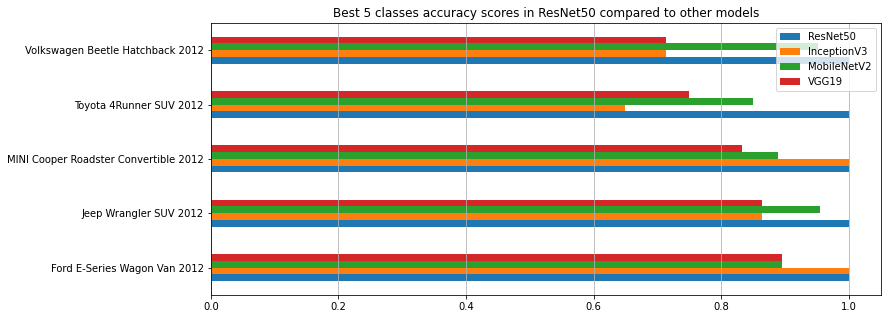

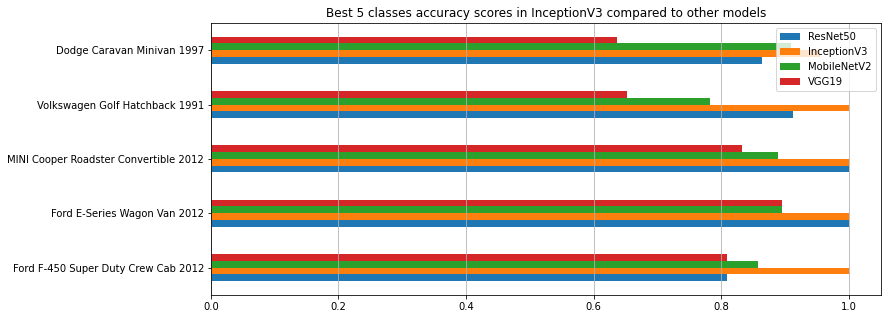

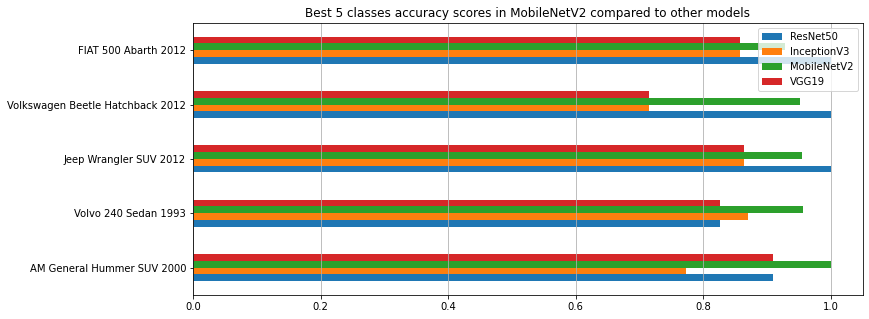

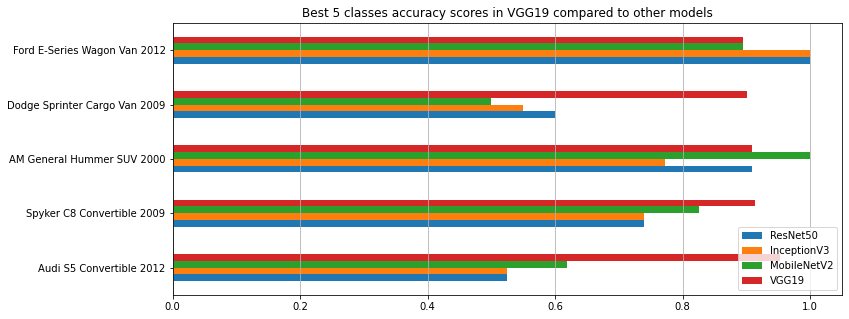

In [46]:
n = 5
for name in names:
    best = classes_accuracy_crop[name].nlargest(n).index
    classes_accuracy_crop.loc[best].plot.barh(figsize=(12, 5), antialiased=True,
                                              title=f"Best {n} classes accuracy scores in {name} compared to other models")
    plt.grid(axis="x")
    plt.show()

Top 5 classes accuracy scores for:
- ResNet50 always hits 100%
- InceptionV3 4 times hits 100%
- MobileNetV2 only once hits 100%
- VGG19 never hits 100%

Comparing accuracies for categories presented on all plots above, it can be said that ResNet50 model stands out in terms of high accuracy. MobileNetV2 also have pretty high scores for most cases.

There is an iteresting observation, that the worst model (VGG19) does a good job with recognition *Dodge Sprinter Cargo Van 2009* and *Audi S5 Converible 2012* (about 90% and 97%). For mentioned car brands, different models have about 60% accuracy max.

<a name='9Bb'></a>
#### b) Worst categories for each model compared to the same categories of other models (cropped images)

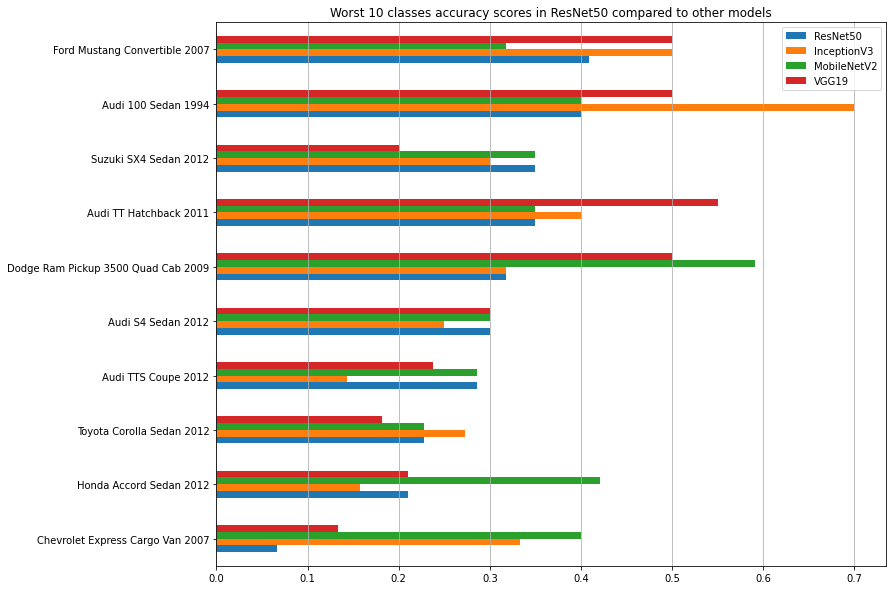

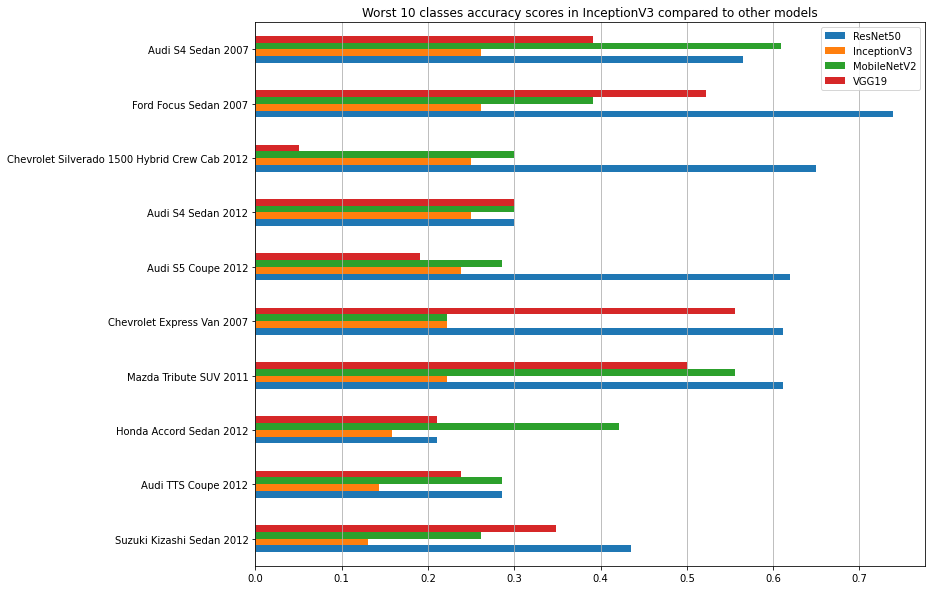

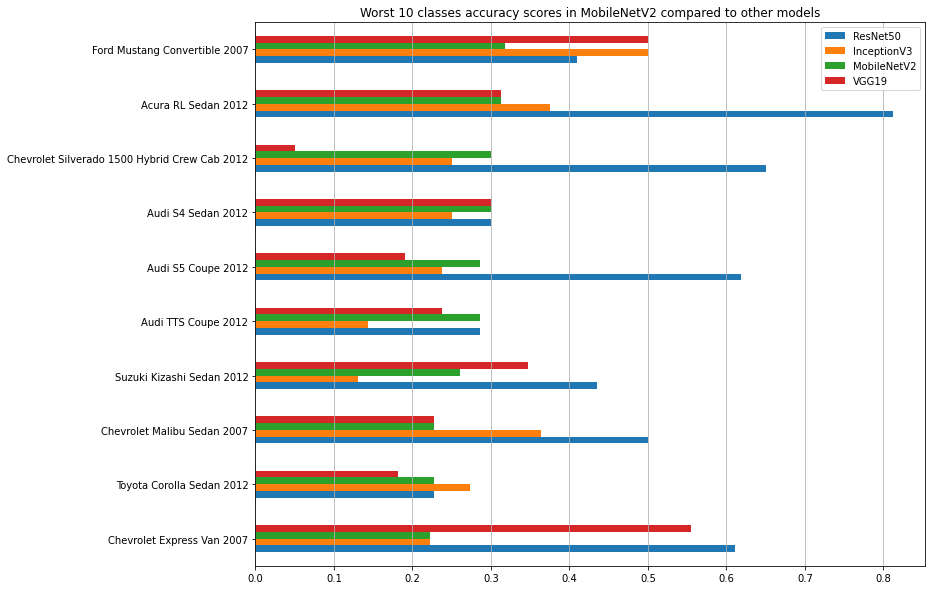

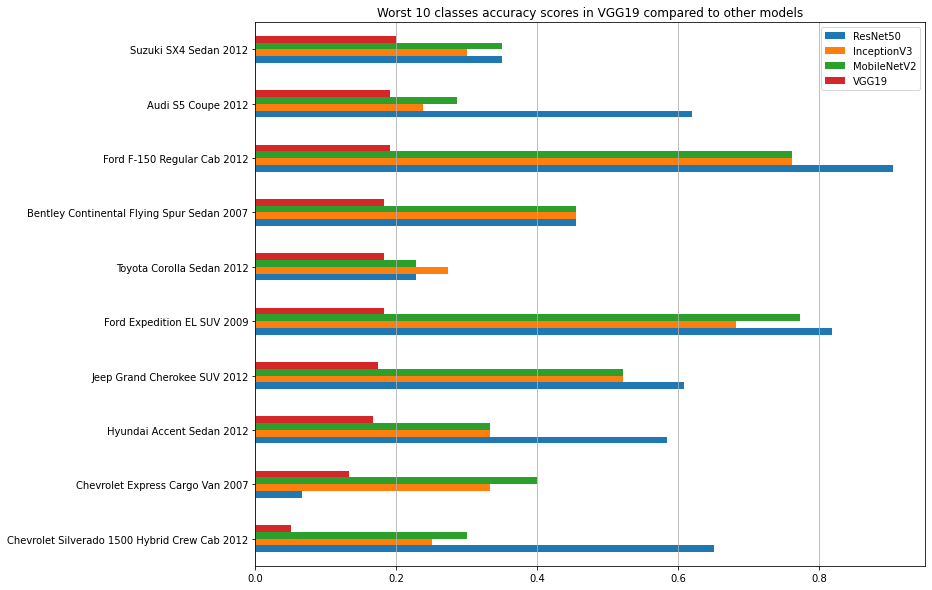

In [47]:
n = 10
for name in names:
    worst = classes_accuracy_crop[name].nsmallest(n).index
    classes_accuracy_crop.loc[worst].plot.barh(figsize=(12, 10), antialiased=True,
                                               title=f"Worst {n} classes accuracy scores in {name} compared to other models"
                                              )
    plt.grid(axis="x")
    plt.show()

In the plot for worst ten ResNet50 categories, we can draw a conclustion, that where ResNet50 does not do good job, combining three remaining models all together might sometimes (4 of 10 times accuracy over 50%) give a much better results.

On the other hand, ResNet50 is a best use in those cases, where other models have a low performance (worst categories for InceptionV3, MobileNetV2 and VGG19)

<a name='9Bc'></a>
#### c) Best categories for each model compared to the same categories of other models (orginal resolution images)

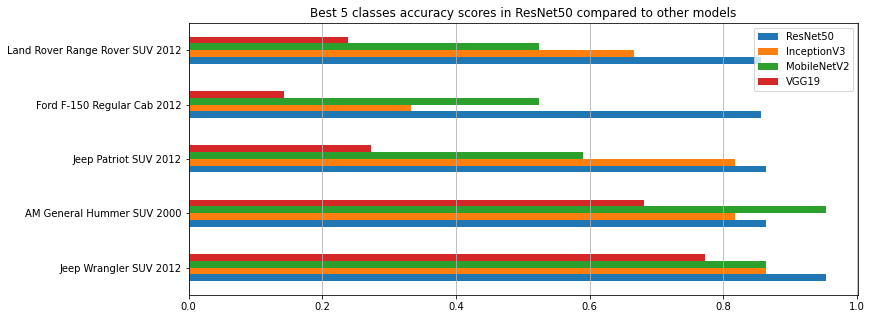

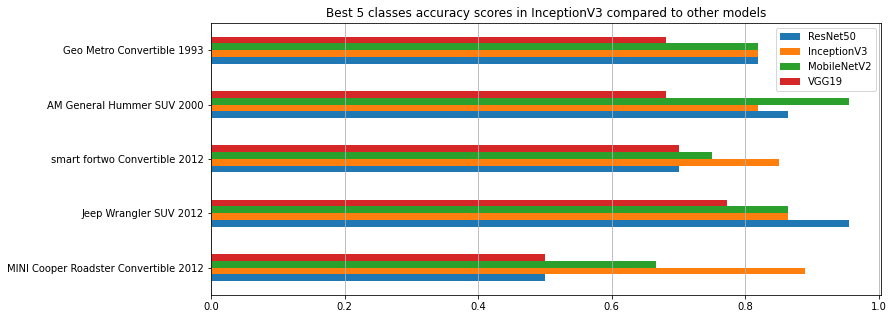

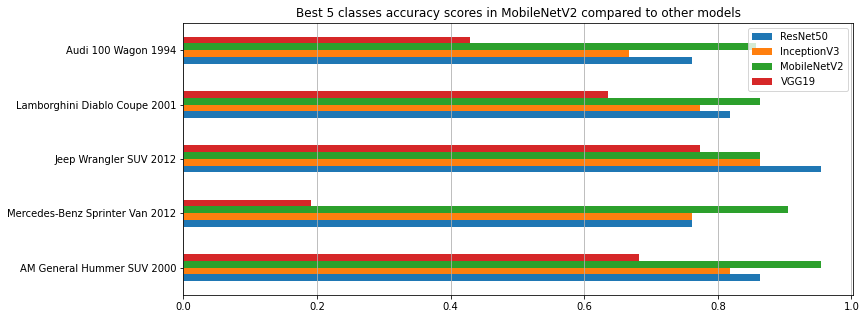

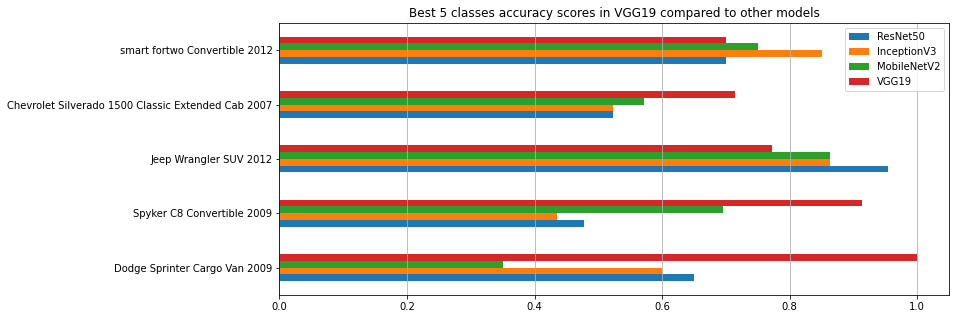

In [48]:
n = 5
for name in names:
    best = classes_accuracy_original[name].nlargest(n).index
    classes_accuracy_original.loc[best].plot.barh(figsize=(12, 5), antialiased=True,
                                                  title=f"Best {n} classes accuracy scores in {name} compared to other models")
    plt.grid(axis="x")
    plt.show()

The same conclusion as for best scores for cropped images can be made - ResNet50 model stands out in terms of high accuracy. MobileNetV2 also does a pretty good job. What is more, InceptionV3 model more ofen appear with a quite high accuracy score. VGG19 is still on the last place.


There is one case, where accuracy hits 100% and this score was obtained for VGG19. Once again, there is no better model in the case of recognizing *Dodge Sprinter Cargo Van 2009*.

<a name='9Bd'></a>
#### d) Worst categories for each model compared to the same categories of other models (orginal resolution images)

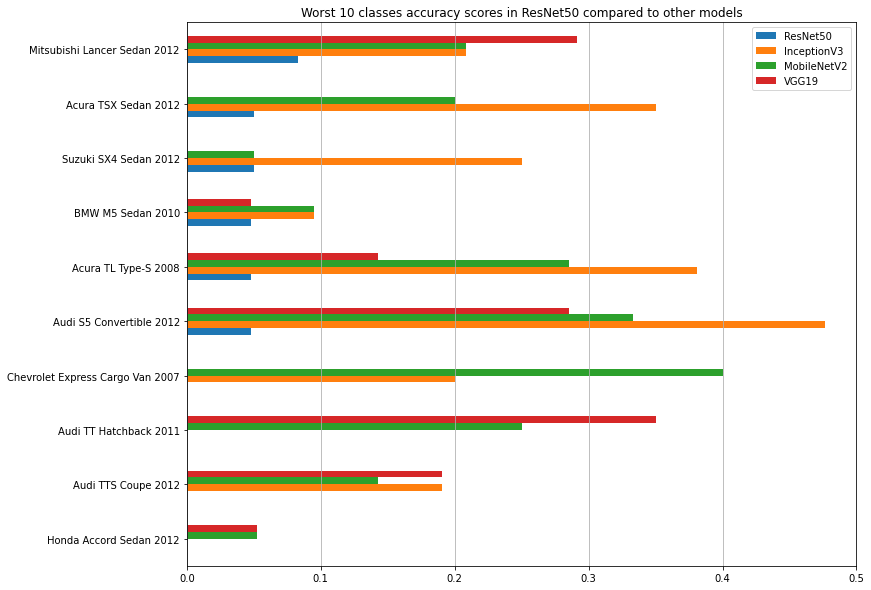

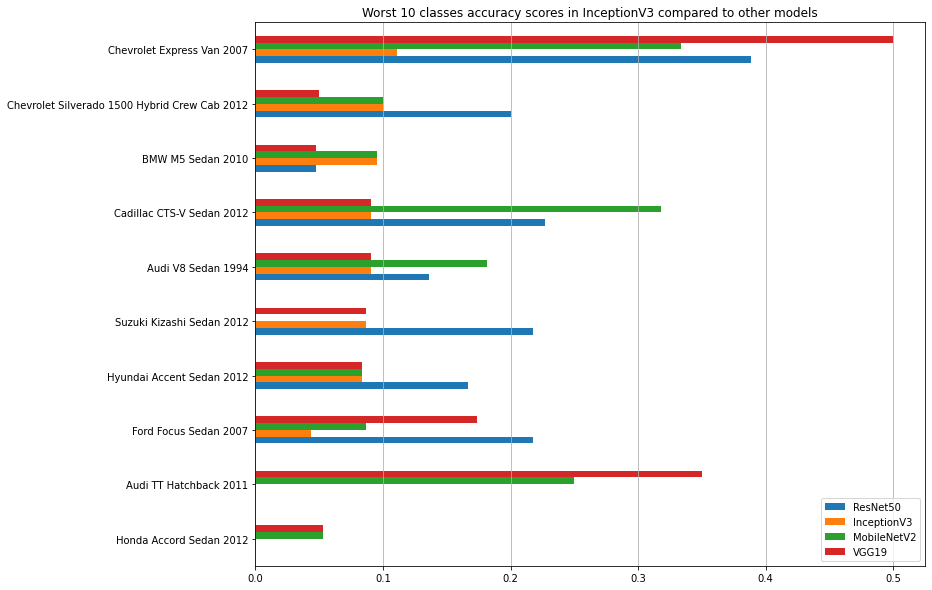

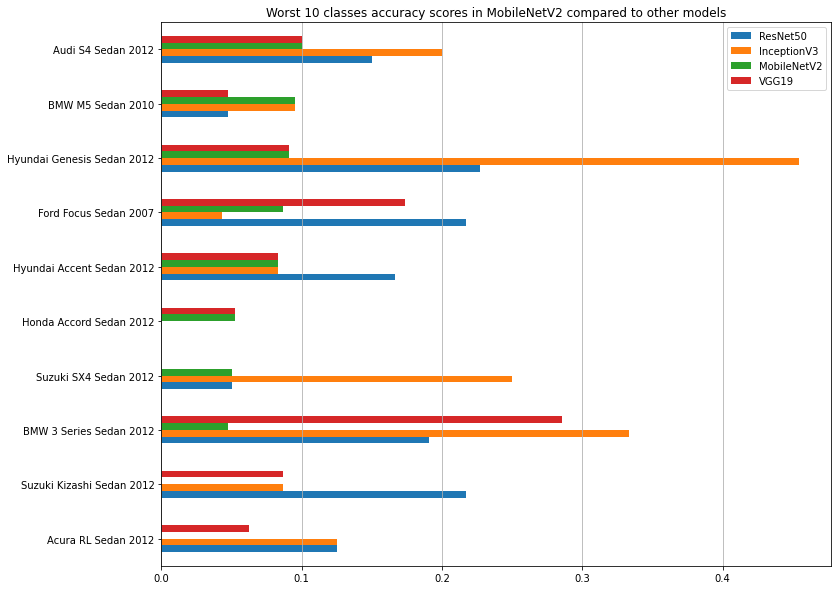

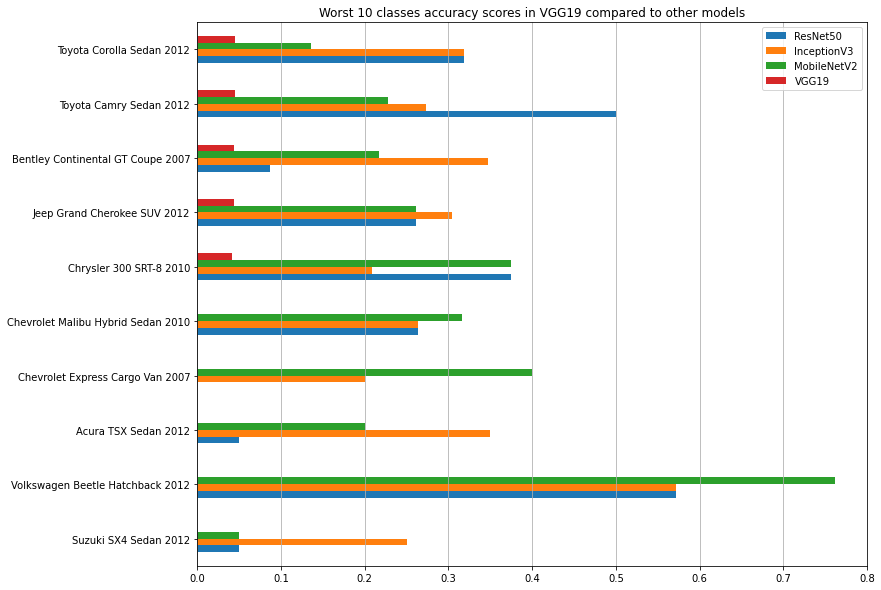

In [49]:
n = 10
for name in names:
    worst = classes_accuracy_original[name].nsmallest(n).index
    classes_accuracy_original.loc[worst].plot.barh(figsize=(12, 10), antialiased=True,
                                                   title=f"Worst {n} classes accuracy scores in {name} compared to other models")
    plt.grid(axis="x")
    plt.show()

Where ResNet50 has a low performance, the InceptionV3 does better job than all other models, but its accuracy it still low. In none of the cases it reaches 50%.

For other models worst categories, there is no model that stands out (often) in terms of high accuracy.

<a name='9C'></a>
### C. Comparison of the same models on different test sets (cropped vs orginal resolution)

<a name='9Ca'></a>
#### a) Best categories on cropped images test set

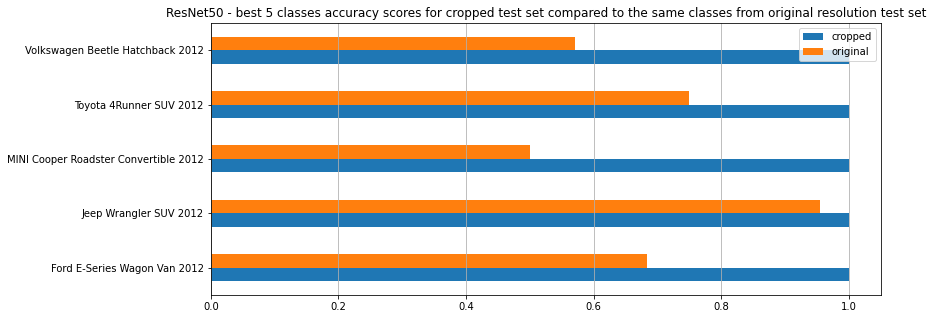

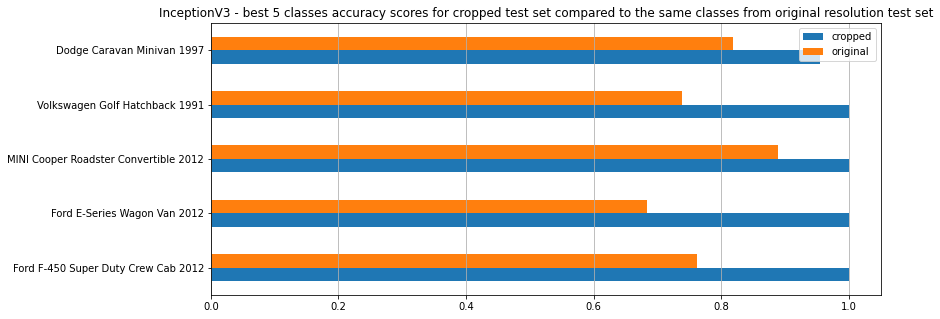

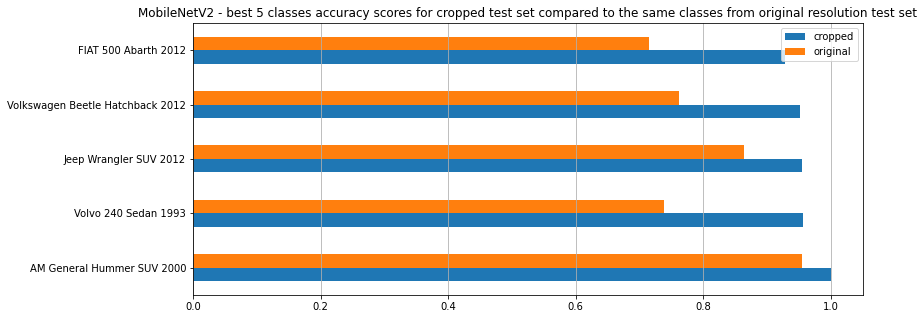

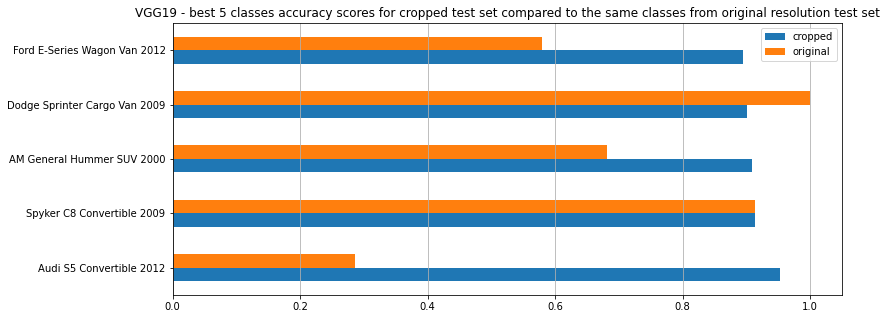

In [50]:
n = 5
for name in names:
    best = classes_accuracy_crop[name].nlargest(n).index
    scores_cropped = classes_accuracy_crop[name].loc[best].values
    scores_original = classes_accuracy_original[name].loc[best].values
    scores_combined = pd.DataFrame(index=best, data = {"cropped": scores_cropped, "original":scores_original})
    scores_combined.plot.barh(figsize=(12, 5), antialiased=True,
                              title=f"{name} - best {n} classes accuracy scores for cropped test set compared to the same classes from original resolution test set")
    plt.grid(axis="x")
    plt.show()

Satistying performace on the same categories for test set with cropped images as well as on those one with original resolution, is obtained for InceptionV3 and MobileNetV2.

For ResNet50 model, we can see that performance on both types of test sets differs significantly.

In case of VGG19 model, some categories have very similar performance, whereas others have a huge difference.

<a name='9Cb'></a>
#### b) Worst categories on cropped images test set

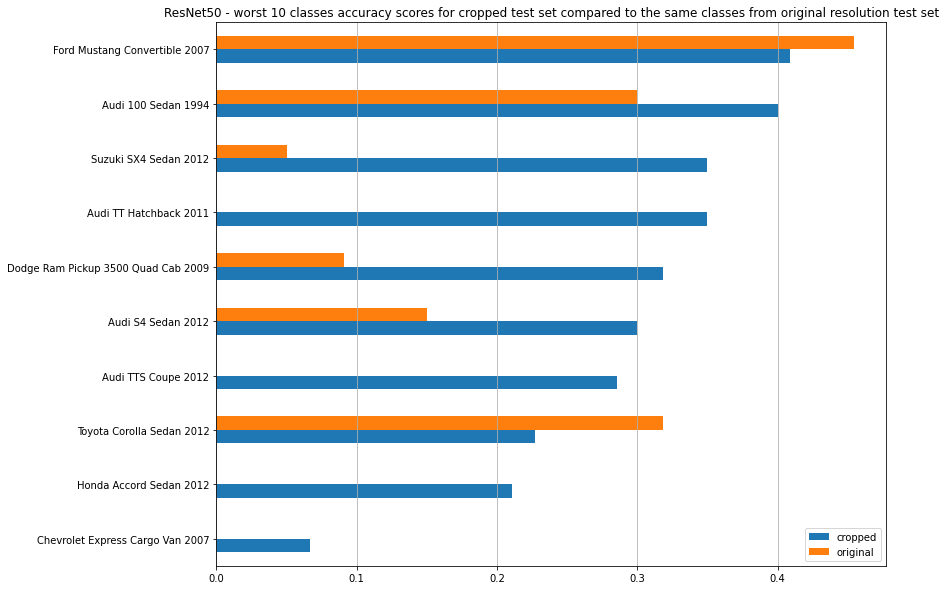

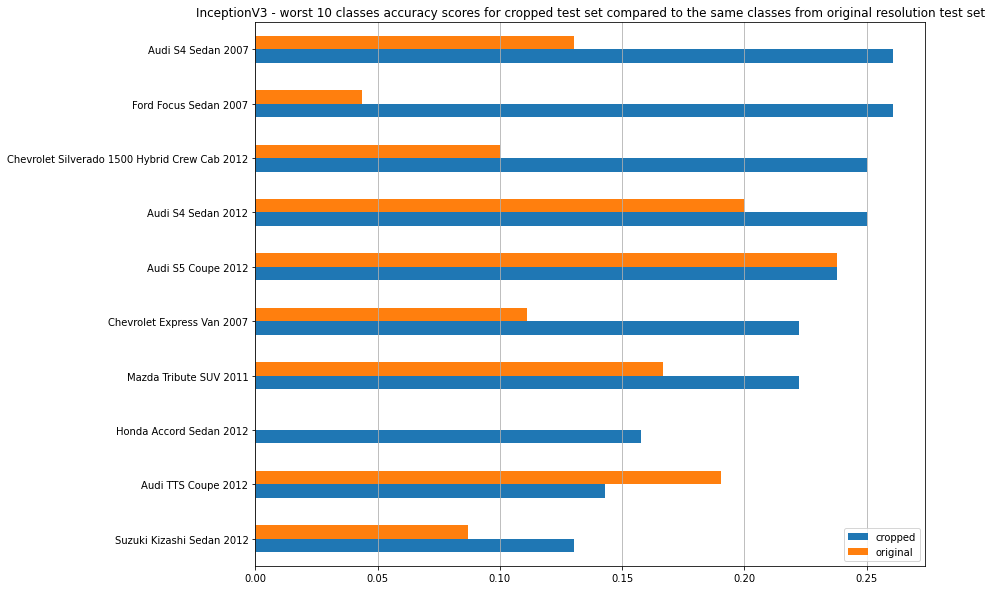

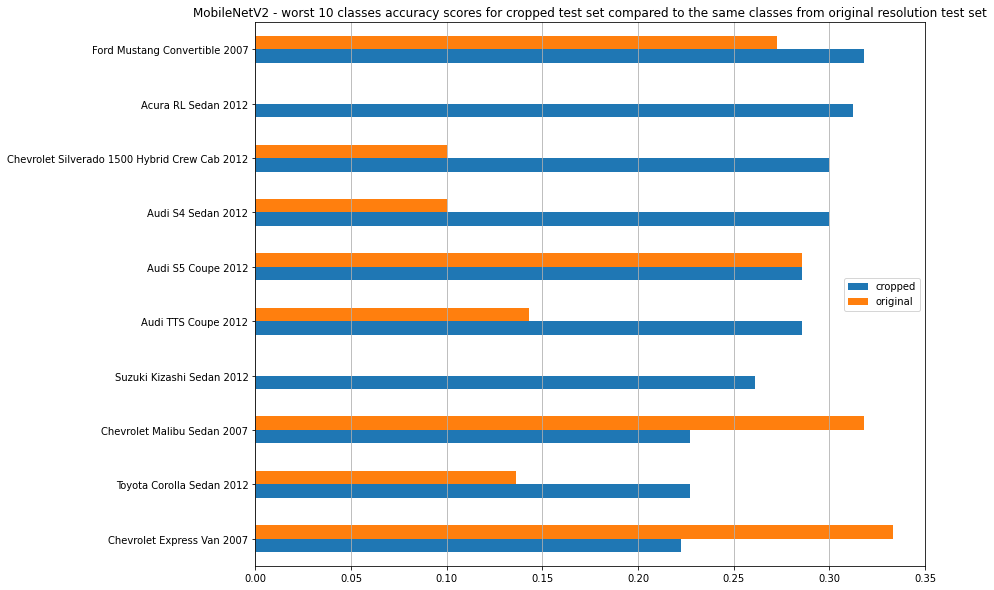

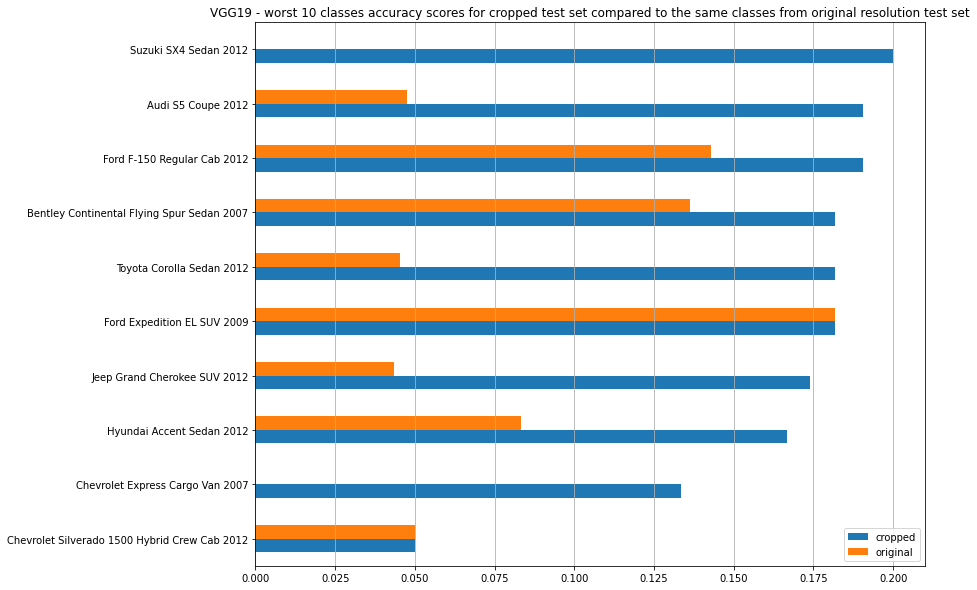

In [51]:
n = 10
for name in names:
    worst = classes_accuracy_crop[name].nsmallest(n).index
    scores_cropped = classes_accuracy_crop[name].loc[worst].values
    scores_original = classes_accuracy_original[name].loc[worst].values
    scores_combined = pd.DataFrame(index=worst, data = {"cropped": scores_cropped, "original":scores_original})
    scores_combined.plot.barh(figsize=(12, 10), antialiased=True,
                              title=f"{name} - worst {n} classes accuracy scores for cropped test set compared to the same classes from original resolution test set")
    plt.grid(axis="x")
    plt.show()

The intuition in this case is as follows: 

*If a model is trained on cropped version of an image, it should performe better on a test set with cropped images than test set with orginal resolution images.* 

This is true most of the time, but there are some cases, where models perform better on images with different distribution from the one that they were trained on.

<a name='9Cc'></a>
#### c) Best categories on test set with orginal image resolution

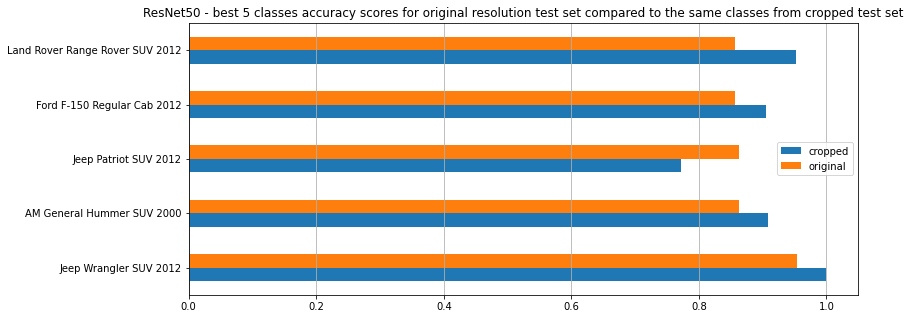

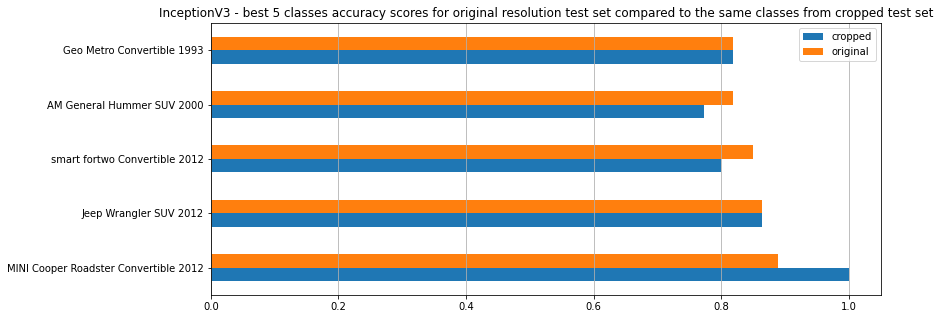

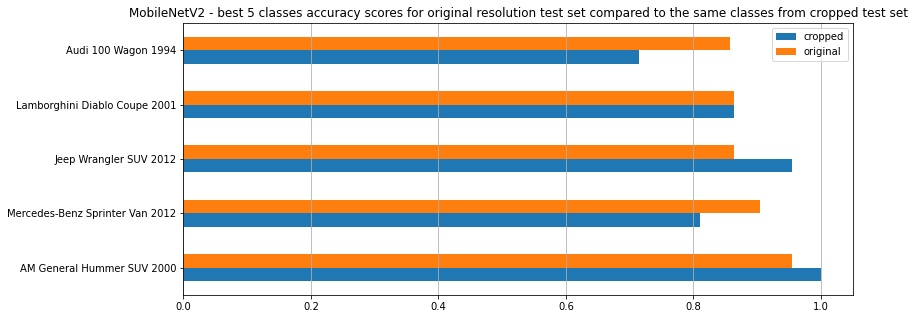

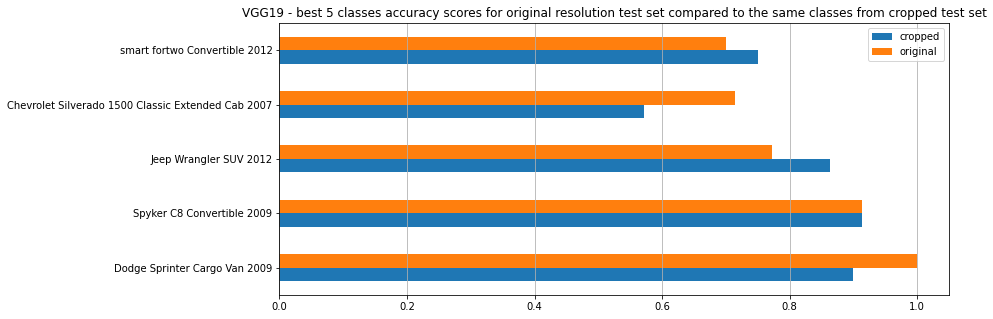

In [52]:
n = 5
for name in names:
    best = classes_accuracy_original[name].nlargest(n).index
    scores_cropped = classes_accuracy_crop[name].loc[best].values
    scores_original = classes_accuracy_original[name].loc[best].values
    scores_combined = pd.DataFrame(index=best, data = {"cropped": scores_cropped, "original":scores_original})
    scores_combined.plot.barh(figsize=(12, 5), antialiased=True,
                              title=f"{name} - best {n} classes accuracy scores for original resolution test set compared to the same classes from cropped test set")
    plt.grid(axis="x")
    plt.show()

Most of the time, accuracies for the same categories, regarding cropped or original resolution test set, are the same.

<a name='9Cd'></a>
#### d) Worst categories on test set with orginal image resolution

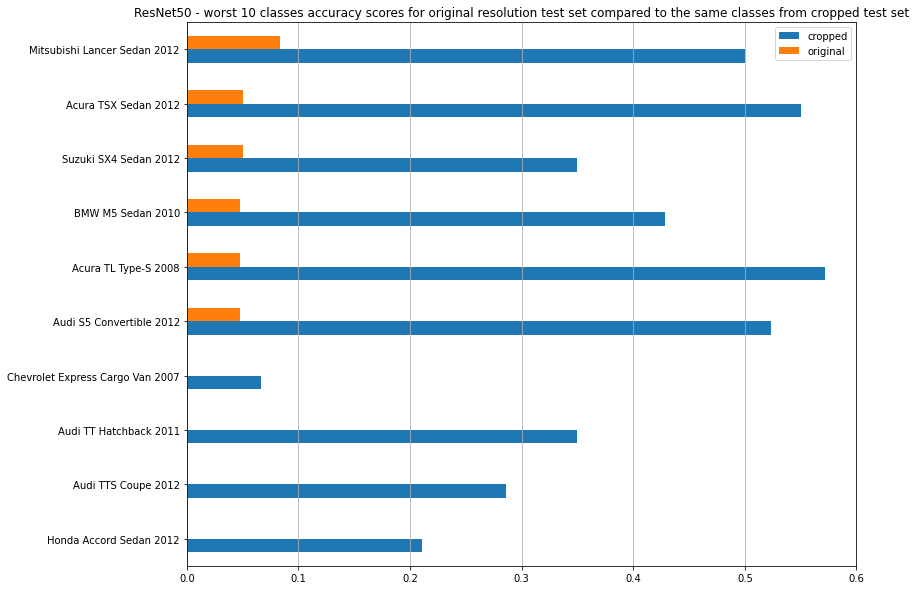

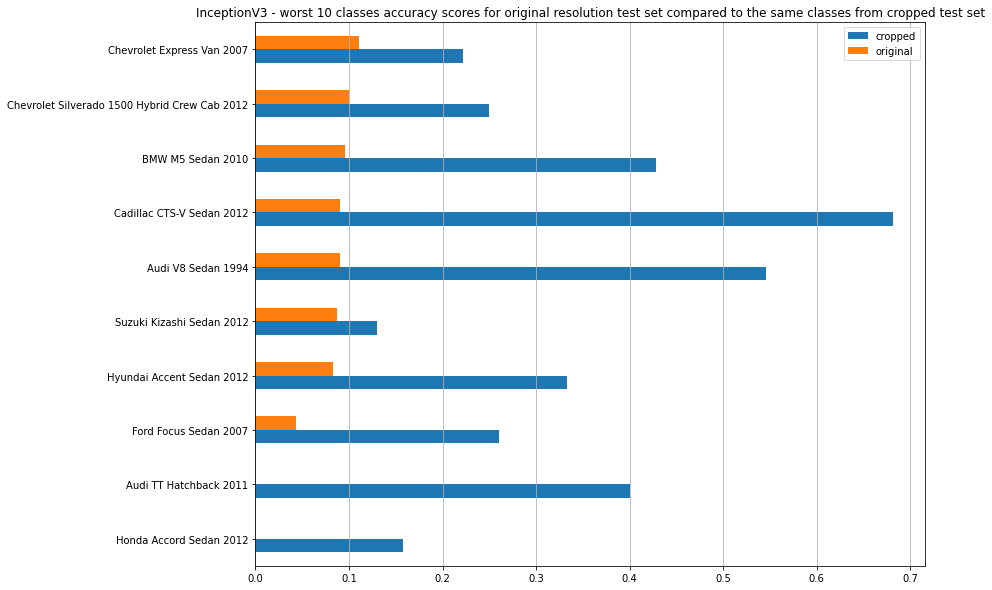

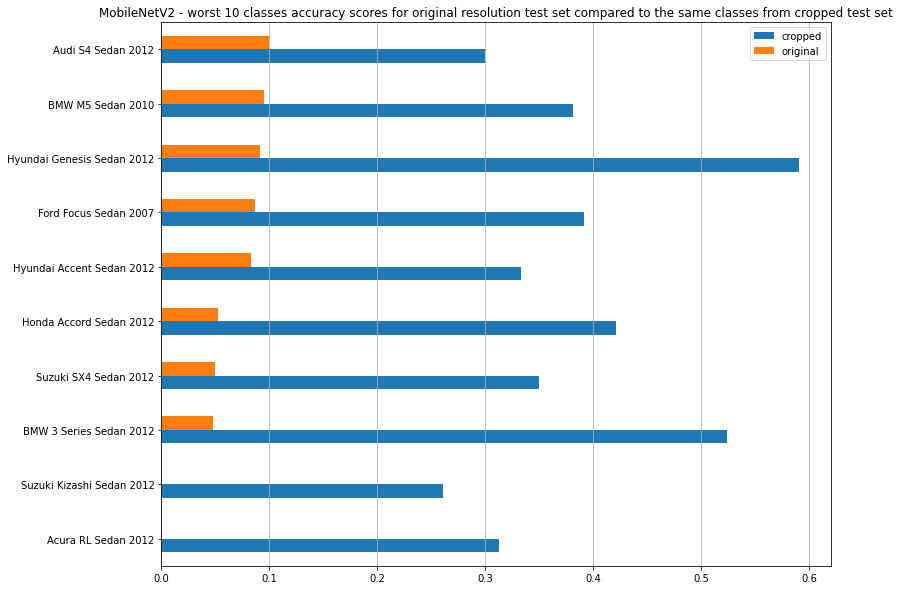

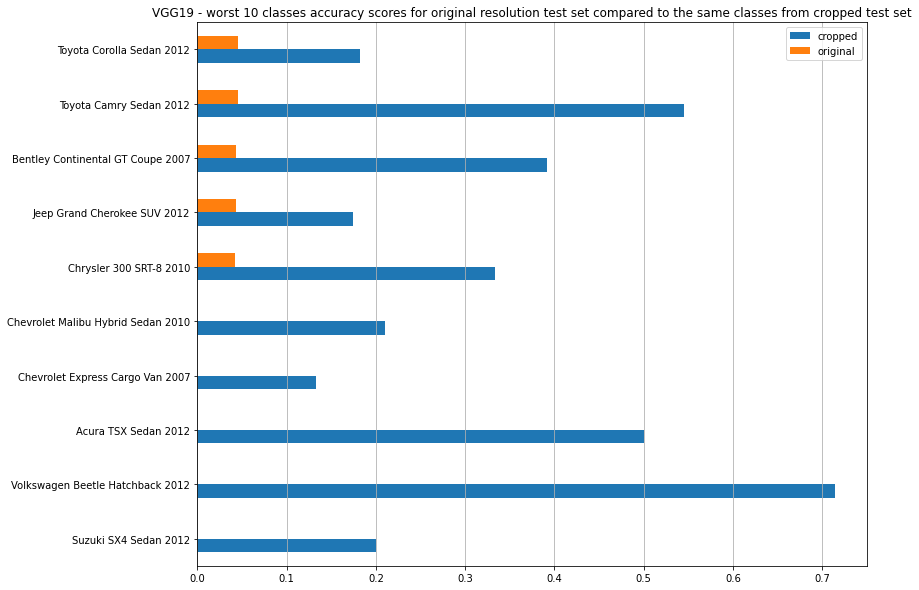

In [53]:
n = 10
for name in names:
    worst = classes_accuracy_original[name].nsmallest(n).index
    scores_cropped = classes_accuracy_crop[name].loc[worst].values
    scores_original = classes_accuracy_original[name].loc[worst].values
    scores_combined = pd.DataFrame(index=worst, data = {"cropped": scores_cropped, "original":scores_original})
    scores_combined.plot.barh(figsize=(12, 10), antialiased=True,
                              title=f"{name} - worst {n} classes accuracy scores for original resolution test set compared to the same classes from cropped test set")
    plt.grid(axis="x")
    plt.show()

Graphs above shows the worst accuriacies of model with respect to testing on test set with orginal image resolution. Accuracy score are, in the best cases, equal to 10% on original images. On the other hand, if a model were to classify the cropped version of the same images, it would have significantly better performance.

<a name='10'></a>
## 10. Fine-tuning the best models

In this section, the ResNet50 and MobileNetV2 models will be fine-tuned. Some layer from base model are going to be unfrozen and trained. This should probably provide a better accuracy score. What is more, a dropout rate will be changed to avoid overfitting in last layers.

In [54]:
def model_fine_tune(model_old, fine_tune_at, dropout_rate=0.3, learning_rate=0.0001):
    
    base_model = model_old.layers[1]
    base_model.trainable = True
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  
        
    for i in [3, 5, 7]:
        model_old.layers[i].rate = dropout_rate
    
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model_old.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'])

If the model weights were not loaded by the user in section 9, run the code below.

In [51]:
# resnet50_model.load_weights("weights/resnet50.h5")
# mobilenet_v2_model.load_weights("weights/mobilenetv2.h5")

<a name='10A'></a>
### A. ResNet50 fine-tuning

In [55]:
model_fine_tune(resnet50_model, 135, 0.5)
resnet50_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                             

The amount of parameters that will be trained during training is now equal to over 19 million.

<span style="color:red">**Note for grader:** The cell bellow fits a model and saves the best weights in given localization from *model_checkpoint* function. It also saves training history. Running this cell might take some time. Weight obtained during training as well as training history, which are provided in this repo, will be loaded later </span>

In [53]:
# checkpoint_resnet50_fine_tuned = model_checkpoint("resnet50_fine_tuned")

# resnet50_history_fine_tuned = resnet50_model.fit(ds_train_resnet50, validation_data=ds_val_resnet50, epochs=15,
#                                                  callbacks=[checkpoint_resnet50_fine_tuned])

# with open("training_history/resnet50_fine_tuned.pickle", "wb") as f:
#     pickle.dump(resnet50_history_fine_tuned.history, f)

Epoch 1/15
255/255 [==============================] - ETA: 0s - loss: 1.4189 - sparse_categorical_accuracy: 0.6012
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.70380, saving model to weights\resnet50_fine_tuned.h5
255/255 [==============================] - 1196s 5s/step - loss: 1.4189 - sparse_categorical_accuracy: 0.6012 - val_loss: 1.0983 - val_sparse_categorical_accuracy: 0.7038
Epoch 2/15
255/255 [==============================] - ETA: 0s - loss: 0.9700 - sparse_categorical_accuracy: 0.7135
Epoch 2: val_sparse_categorical_accuracy improved from 0.70380 to 0.71637, saving model to weights\resnet50_fine_tuned.h5
255/255 [==============================] - 1155s 5s/step - loss: 0.9700 - sparse_categorical_accuracy: 0.7135 - val_loss: 1.0264 - val_sparse_categorical_accuracy: 0.7164
Epoch 3/15
255/255 [==============================] - ETA: 0s - loss: 0.7317 - sparse_categorical_accuracy: 0.7770
Epoch 3: val_sparse_categorical_accuracy improved from 0.71637 to 0.7503

<a name='10B'></a>
### B. MobileNetV2 fine-tuning

In [56]:
model_fine_tune(mobilenet_v2_model, 120, 0.5)
mobilenet_v2_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0   

<span style="color:red">**Note for grader:** The cell bellow fits a model and saves the best weights in given localization from *model_checkpoint* function. It also saves training history. Running this cell might take some time. Weight obtained during training as well as training history, which are provided in this repo, will be loaded later </span>

In [56]:
# checkpoint_mobilenet_v2_fine_tuned = model_checkpoint("mobilenet_v2_fine_tuned")

# mobilenet_v2_history_fine_tuned = mobilenet_v2_model.fit(ds_train_mobilenet_v2, validation_data=ds_val_mobilenet_v2,
#                                                          epochs=15, callbacks=[checkpoint_mobilenet_v2_fine_tuned])

# with open("training_history/mobilenet_v2_fine_tuned.pickle", "wb") as f:
#     pickle.dump(mobilenet_v2_history_fine_tuned.history, f)

Epoch 1/15
255/255 [==============================] - ETA: 0s - loss: 2.2962 - sparse_categorical_accuracy: 0.4036
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.56726, saving model to weights\mobilenet_v2_fine_tuned.h5
255/255 [==============================] - 305s 1s/step - loss: 2.2962 - sparse_categorical_accuracy: 0.4036 - val_loss: 1.6486 - val_sparse_categorical_accuracy: 0.5673
Epoch 2/15
255/255 [==============================] - ETA: 0s - loss: 1.8610 - sparse_categorical_accuracy: 0.4839
Epoch 2: val_sparse_categorical_accuracy improved from 0.56726 to 0.59794, saving model to weights\mobilenet_v2_fine_tuned.h5
255/255 [==============================] - 306s 1s/step - loss: 1.8610 - sparse_categorical_accuracy: 0.4839 - val_loss: 1.5362 - val_sparse_categorical_accuracy: 0.5979
Epoch 3/15
255/255 [==============================] - ETA: 0s - loss: 1.6392 - sparse_categorical_accuracy: 0.5367
Epoch 3: val_sparse_categorical_accuracy improved from 0.59794 to 

<a name='11'></a>
## 11. Visualization of learning process improvement
The code below will display plots with learning process information. When a line on a plot is dashed, it means, that this is plot for fine-tuned model learning. The process of fine-tuned model learning starts, when weights for earlier model were saved for the last time, i.e. the max accuracy score on validation set. What is more, a dataframe with new scores will be displayed as well

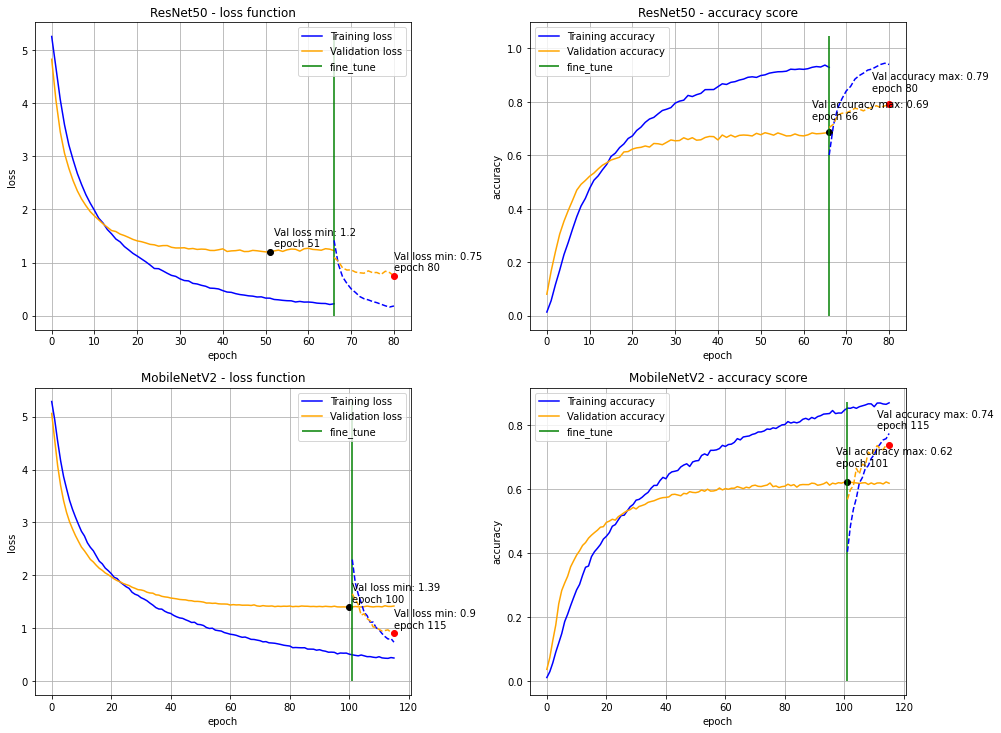

Scores obtained after fine-tuning models:

             training validation
ResNet50      0.93971   0.791049
MobileNetV2  0.773698   0.738999


In [57]:
names_fine = ["ResNet50", "MobileNetV2"]
histories_fine = [('resnet50.pickle', 'resnet50_fine_tuned.pickle'),
                  ('mobilenet_v2.pickle', 'mobilenet_v2_fine_tuned.pickle')]
training_scores_fine = pd.DataFrame(index=names_fine, columns=["training", "validation"])

plt.figure(figsize=(14, 20))
for i, (name, hist_file) in enumerate(zip(names_fine, histories_fine)):
    
    path = os.path.join("training_history", hist_file[0])
    with open(path, "rb") as model_history:
        temp_history = pickle.load(model_history)
    loss = temp_history["loss"]
    val_loss = temp_history["val_loss"]
    sparse_categorical_accuracy = temp_history["sparse_categorical_accuracy"]
    val_sparse_categorical_accuracy = temp_history["val_sparse_categorical_accuracy"]
    min_val_loss, val_loss_idx = np.min(val_loss), np.argmin(val_loss)
    max_val_acc, val_acc_idx = np.max(val_sparse_categorical_accuracy), np.argmax(val_sparse_categorical_accuracy)
    
    path = os.path.join("training_history", hist_file[1])
    with open(path, "rb") as model_history:
        temp_history = pickle.load(model_history)
    loss_fine = temp_history["loss"]
    val_loss_fine = temp_history["val_loss"]
    sparse_categorical_accuracy_fine = temp_history["sparse_categorical_accuracy"]
    val_sparse_categorical_accuracy_fine = temp_history["val_sparse_categorical_accuracy"]
    min_val_loss_fine, val_loss_idx_fine = np.min(val_loss_fine), np.argmin(val_loss_fine)
    max_val_acc_fine = np.max(val_sparse_categorical_accuracy_fine)
    val_acc_idx_fine = np.argmax(val_sparse_categorical_accuracy_fine)
    training_scores_fine.loc[name] = sparse_categorical_accuracy_fine[val_acc_idx_fine], val_sparse_categorical_accuracy_fine[val_acc_idx_fine]
    
    plt.subplot(len(histories), 2, 2 * i + 1)
    plt.plot(loss, label="Training loss", color="b")
    plt.plot(val_loss, label="Validation loss", color="orange")
    plt.plot(val_loss_idx, min_val_loss, marker="o", color="k")
    plt.annotate(f"Val loss min: {np.round(min_val_loss, 2)}\nepoch {val_loss_idx}",
                 (val_loss_idx + 1, min_val_loss + 0.1))
    
    plt.vlines(val_acc_idx, 0, max(loss), label="fine_tune", color="green")
    
    plt.plot([x + val_acc_idx for x in range(len(loss_fine))], loss_fine, "b--")
    plt.plot([x + val_acc_idx for x in range(len(val_loss_fine))], val_loss_fine, "--", color="orange")
    plt.plot(val_acc_idx + val_loss_idx_fine, min_val_loss_fine, marker="o", color="r")
    plt.annotate(f"Val loss min: {np.round(min_val_loss_fine, 2)}\nepoch {val_acc_idx + val_loss_idx_fine}",
                 (val_acc_idx + val_loss_idx_fine, min_val_loss_fine + 0.1))   
    
    plt.title(f"{name} - loss function")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.tight_layout()
    plt.legend()
    plt.grid()
    
    plt.subplot(len(histories), 2, 2 * i + 2)
    plt.plot(sparse_categorical_accuracy, label="Training accuracy", color="b")
    plt.plot(val_sparse_categorical_accuracy, label="Validation accuracy", color="orange")
    plt.plot(val_acc_idx, max_val_acc, marker="o", color="k")
    plt.annotate(f"Val accuracy max: {np.round(max_val_acc, 2)}\nepoch {val_acc_idx}",
                 (val_acc_idx - 4, max_val_acc + 0.05))
    plt.vlines(val_acc_idx, 0, max(sparse_categorical_accuracy_fine)+0.1, label="fine_tune", color="green")
    
    plt.plot([x + val_acc_idx for x in range(len(loss_fine))], sparse_categorical_accuracy_fine, "b--")
    plt.plot([x + val_acc_idx for x in range(len(loss_fine))], val_sparse_categorical_accuracy_fine, "--", color="orange")
    plt.plot(val_acc_idx + val_acc_idx_fine, max_val_acc_fine, marker="o", color="r")
    plt.annotate(f"Val accuracy max: {np.round(max_val_acc_fine, 2)}\nepoch {val_acc_idx + val_acc_idx_fine}",
                 (val_acc_idx + val_acc_idx_fine - 4, max_val_acc_fine + 0.05))
    
    plt.title(f"{name} - accuracy score")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.tight_layout()
    plt.legend()
    plt.grid()
plt.show()

print("Scores obtained after fine-tuning models:\n")
print(training_scores_fine)

Both models improved by about 10% on validation set

<a name='12'></a>
## 12. Fine-tuned models perforamnce on a test set
First of all, let's upload weights for ResNet50 model and MobileNetV2.

In [58]:
resnet50_model.load_weights("weights/resnet50_fine_tuned.h5")
mobilenet_v2_model.load_weights("weights/mobilenet_v2_fine_tuned.h5")

<a name='12A'></a>
### A. Total accuracy scores

In [59]:
models_fine = [resnet50_model, mobilenet_v2_model]
accuracy_scores_fine = pd.DataFrame(index=names_fine, columns = ["test_cropped", "test_original"])

for name, model in zip(names_fine, models_fine):
    print("--------------------------------------")
    print(f"Calculating accuracy for {name} model")
    ds_test_cropped = datasets_tf.loc[name]["test"]
    ds_test_original = datasets_tf.loc[name]["test_original"]
    accuracy_scores_fine.loc[name]["test_cropped"] = model.evaluate(ds_test_cropped)[1]
    accuracy_scores_fine.loc[name]["test_original"] = model.evaluate(ds_test_original)[1]
    print("--------------------------------------")
accuracy_scores_fine

--------------------------------------
Calculating accuracy for ResNet50 model
4064/4064 [==============================] - 552s 136ms/step - loss: 1.9509 - sparse_categorical_accuracy: 0.5480
--------------------------------------
--------------------------------------
Calculating accuracy for MobileNetV2 model
4064/4064 [==============================] - 151s 37ms/step - loss: 1.9808 - sparse_categorical_accuracy: 0.5108
--------------------------------------


test_cropped test_original
ResNet50        0.796014      0.547982
MobileNetV2     0.745571      0.510827

Both models improved significantly. The output cell of a line below present exact value of improvement

In [60]:
accuracy_scores_fine.loc[["ResNet50", "MobileNetV2"]] - accuracy_scores.loc[["ResNet50", "MobileNetV2"]]

test_cropped test_original
ResNet50        0.097933      0.126969
MobileNetV2     0.119833      0.125984

<a name='12B'></a>
### B. How exactly categories did improve

<span style="color:red">**Note for grader:** The cell below calculates accuracy for each class for Resnet50 and MobileNetV2 improved models on two test sets (cropped and original resolution). Running the code below might take some time. Instead of waiting for results, you can always load them from a file (the next cell), because they were calculated earlier and saved. </span>

In [68]:
# classes_accuracy_crop_fine = pd.DataFrame(index=class_names.values())
# classes_accuracy_original_fine = pd.DataFrame(index=class_names.values())

# for name, model in zip(names_fine, models_fine):
#     print(f"Calculating multiclass accuracies for improved {name} model")
#     classes_accuracy_crop_fine[name] = multiclass_accuracy(datasets_tf.loc[name]["test"], model)
#     classes_accuracy_original_fine[name] = multiclass_accuracy(datasets_tf.loc[name]["test_original"], model)

# with open("additional_files/classes_accuracy_crop_fine.pickle", "wb") as f:
#     pickle.dump(classes_accuracy_crop_fine, f)
# with open("additional_files/classes_accuracy_original_fine.pickle", "wb") as f:
#     pickle.dump(classes_accuracy_original_fine, f)

Calculating multiclass accuracies for improved ResNet50 model
Calculating multiclass accuracies for improved MobileNetV2 model


In [61]:
with open("additional_files/classes_accuracy_crop_fine.pickle", "rb") as f:
    classes_accuracy_crop_fine = pickle.load(f)
with open("additional_files/classes_accuracy_original_fine.pickle", "rb") as f:
    classes_accuracy_original_fine = pickle.load(f)

In [62]:
# this line fixes problems with class names/tensorflow folder structure order
classes_accuracy_crop_fine.index = correct_indexes
classes_accuracy_original_fine.index = correct_indexes

Let's find classes which improved the most and the least for ResNet50 and MobileNetV2. Let also check how many categories decreased in accuracy, how many did not change and how many improved

In [63]:
def print_cateogrical_differences(new, old, mode="best", n=5):
    diff = new - old
    if mode == "check":
        downgrade = (diff < 0).sum()
        not_affected = (diff == 0).sum()
        upgrade = (diff > 0).sum()
        print(f"{upgrade} categories improved", f"{not_affected} categories did not improved nor downgrade",
              f"{downgrade} decresed in accuracy score", sep="\n")
    else:
        if mode == "best":
            diff = (new - old).nlargest(5)
        elif mode == "worst":
            diff = (new - old).nsmallest(5)
        indexes = diff.index
        print(np.round(pd.DataFrame(index=indexes, data={"before" : old.loc[indexes],
                                                 "after" : new.loc[indexes], 
                                                 "improvement" : diff.values}), 2))

In [64]:
for name in names_fine:
    for mode in ["best", "worst", "check"]:
        print("-----------------------------------------------------------------------------")
        print(f"{name} - the {mode} improvement on cropped version of a test set")
        print_cateogrical_differences(classes_accuracy_crop_fine[name], classes_accuracy_crop[name], mode)
        print(f"\n{name} - the {mode} improvement on test set with original image resolution")
        print_cateogrical_differences(classes_accuracy_original_fine[name], classes_accuracy_original[name], mode)
        print("-----------------------------------------------------------------------------")

-----------------------------------------------------------------------------
ResNet50 - the best improvement on cropped version of a test set
                                                    before  after  improvement
Honda Accord Sedan 2012                               0.21   0.89         0.68
BMW M5 Sedan 2010                                     0.43   0.95         0.52
Toyota Corolla Sedan 2012                             0.23   0.68         0.45
Rolls-Royce Phantom Drophead Coupe Convertible ...    0.53   0.93         0.40
Ford Mustang Convertible 2007                         0.41   0.77         0.36

ResNet50 - the best improvement on test set with original image resolution
                                     before  after  improvement
Ford Ranger SuperCab 2011              0.24   0.76         0.52
Land Rover LR2 SUV 2012                0.14   0.57         0.43
Hyundai Sonata Hybrid Sedan 2012       0.12   0.53         0.41
Cadillac Escalade EXT Crew Cab 2007    0.41   0.82 

If the value in *improvement* column have a negative sign, it means that the model decreased in accuracy for this category.
<a name='13'></a>
## 13. Testing hypothesic from section Statistics (4B)
Before, the testing of the hypothesis begins, there is one thing that should be done. The test will be performed on the best models:
- ResNet50 (fine-tuned)
- InceptionV3
- MobileNetV2 (fine-tuned)
- VGG19

In that case, dataframes with accuracy scores for each class are needed to be combine into one, containing results for models mentioned above.

In [65]:
indexes = classes_accuracy_crop.index
classes_accuracy_crop_combined = pd.DataFrame({"ResNet50" : classes_accuracy_crop_fine["ResNet50"],
                                               "InceptionV3" : classes_accuracy_crop["InceptionV3"],
                                               "MobileNetV2" : classes_accuracy_crop_fine["MobileNetV2"], 
                                               "VGG19" : classes_accuracy_crop["VGG19"]},
                                              index=indexes)
classes_accuracy_original_combined = pd.DataFrame({"ResNet50" : classes_accuracy_original_fine["ResNet50"],
                                                   "InceptionV3" : classes_accuracy_original["InceptionV3"],
                                                   "MobileNetV2" : classes_accuracy_original_fine["MobileNetV2"],
                                                   "VGG19" : classes_accuracy_original["VGG19"]},
                                                   index=indexes)

In [66]:
def hypothesis_test(hypothesis_original, class_names, classes_accuracy):
    hypothesis = hypothesis_original.copy()
    hypothesis = pd.DataFrame(hypothesis)
    cl = np.array(hypothesis.index).astype(int)
    index_names = [class_names[x] for x in cl]
    hypothesis.index = index_names
    positions = len(class_names) - 1
    for model_name in list(classes_accuracy_crop_combined.columns):
        score_place = []
        for brand in index_names:
            brand_acc = classes_accuracy.loc[brand][model_name]
            position_number = np.max(np.where(np.array(sorted(classes_accuracy[model_name])) == brand_acc))
            place = positions - position_number
            score_place.append(place)
        hypothesis[model_name] = classes_accuracy.loc[index_names][model_name]
        hypothesis[f"{model_name} #place"] = score_place
        if len(index_names) > 1:
            corr = np.round(np.corrcoef(score_place, hypothesis["train"])[0][1], 2)
            print("--------------------------------------------------------")
            print(model_name)
            print(f"Pearson correlaction between number of samples and #place {corr}")
    hypothesis.sort_values(by=["train"], inplace=True)
    return np.round(hypothesis, 2)

Before displaying the results, there are few thing that need to be mentioned about column names:
- column "train" refers to number of observations for excat car brand in training set
- column *model* for example *ResNet50* reffers to accuracy score for this model in a given category (class)
- *model #place* mean which place is given for this cathegory's accuracy, where 0 means the best and 195 mean the worst
- the hypothesis will only be tested on cropped test set, becasue model better fits to it (dataframe for orginal test set, that combines results for *normal* and *fine-tuned* models is defined for later use)

Let's see the class with the highest numbers of observations:

In [67]:
hypothesis_test(h_best_score, class_names, classes_accuracy_crop_combined)

train  ResNet50  ResNet50 #place  InceptionV3  \
GMC Savana Van 2012     68      0.76              124         0.62   

                     InceptionV3 #place  MobileNetV2  MobileNetV2 #place  \
GMC Savana Van 2012                  96         0.82                  70   

                     VGG19  VGG19 #place  
GMC Savana Van 2012   0.65            40

Quick reminder. Hypothesis for this group was as follows:

***The model will learn very well to recognize the class with the greatest number of observations probably the best score)***

Hypothesis rejected. In none of the cases, this class is even in top 5.

The second hypothesis:

***The model will be less able to recognize car brands, from groups where fewer photos are provided (lower score for classes from range min-Q1, the target group is exactly where the number of observation is less or equal to 37***

The line below will additionally print correlaction value between number of samples and place

In [68]:
hypothesis_test(h_worst_scores, class_names, classes_accuracy_crop_combined)

--------------------------------------------------------
ResNet50
Pearson correlaction between number of samples and #place -0.12
--------------------------------------------------------
InceptionV3
Pearson correlaction between number of samples and #place -0.1
--------------------------------------------------------
MobileNetV2
Pearson correlaction between number of samples and #place -0.21
--------------------------------------------------------
VGG19
Pearson correlaction between number of samples and #place -0.34


train  ResNet50  \
Hyundai Accent Sedan 2012                              24      0.50   
FIAT 500 Abarth 2012                                   28      1.00   
Maybach Landaulet Convertible 2012                     29      1.00   
Chevrolet Express Cargo Van 2007                       30      0.20   
Rolls-Royce Phantom Drophead Coupe Convertible ...     31      0.93   
Acura RL Sedan 2012                                    32      0.56   
Aston Martin Virage Convertible 2012                   33      0.59   
Bugatti Veyron 16.4 Convertible 2009                   33      0.81   
Infiniti QX56 SUV 2011                                 33      0.94   
Hyundai Sonata Hybrid Sedan 2012                       34      0.88   
Infiniti G Coupe IPL 2012                              34      0.82   
FIAT 500 Convertible 2012                              34      0.82   
BMW ActiveHybrid 5 Sedan 2012                          34      0.88   
Chevrolet Express Van 2007                             35      0.50   
Buick Regal GS 2012                                    35      0.89   
Bentley Continental GT Coupe 2012                      35      0.53   
BMW 1 Series Convertible 2012                          36      0.94   
Lamborghini Reventon Coupe 2008                        36      0.89   
Lamborghini Gallardo LP 570-4 Superleggera 2012        36      0.83   
Mazda Tribute SUV 2011                                 36      0.61   
Bentley Mulsanne Sedan 2011                            36      0.72   
Chevrolet Tahoe Hybrid SUV 2012                        37      0.68   
Bentley Continental Supersports Conv. Convertib...     37      0.89   
Audi RS 4 Convertible 2008                             37      0.94   
Chevrolet HHR SS 2010                                  37      0.83   
MINI Cooper Roadster Convertible 2012                  37      1.00   
Mercedes-Benz SL-Class Coupe 2009                      37      0.94   

                                                    ResNet50 #place  \
Hyundai Accent Sedan 2012                                       184   
FIAT 500 Abarth 2012                                              0   
Maybach Landaulet Convertible 2012                                0   
Chevrolet Express Cargo Van 2007                                194   
Rolls-Royce Phantom Drophead Coupe Convertible ...               42   
Acura RL Sedan 2012                                             177   
Aston Martin Virage Convertible 2012                            175   
Bugatti Veyron 16.4 Convertible 2009                            106   
Infiniti QX56 SUV 2011                                           41   
Hyundai Sonata Hybrid Sedan 2012                                 67   
Infiniti G Coupe IPL 2012                                        94   
FIAT 500 Convertible 2012                                        94   
BMW ActiveHybrid 5 Sedan 2012                                    67   
Chevrolet Express Van 2007                                      184   
Buick Regal GS 2012                                              64   
Bentley Continental GT Coupe 2012                               182   
BMW 1 Series Convertible 2012                                    38   
Lamborghini Reventon Coupe 2008                                  64   
Lamborghini Gallardo LP 570-4 Superleggera 2012                  88   
Mazda Tribute SUV 2011                                          171   
Bentley Mulsanne Sedan 2011                                     146   
Chevrolet Tahoe Hybrid SUV 2012                                 155   
Bentley Continental Supersports Conv. Convertib...               64   
Audi RS 4 Convertible 2008                                       38   
Chevrolet HHR SS 2010                                            88   
MINI Cooper Roadster Convertible 2012                             0   
Mercedes-Benz SL-Class Coupe 2009                                38   

                                                    InceptionV3  \
Hyundai

As we can see there are no strong correlaction between number of samples and ability to recognize model better or worst. This hypothesis is also rejected.

<a name='14'></a>
## 14. Predictions on images from test set (visualization)
In this section multiple images will be loaded and then, all the models will make prediction about a brand of a car presented on an image

In [69]:
def load_img(image_path):
    return plt.imread(image_path)

def get_annots(annos_file, image_name):
    idx = annos_file["annotations"]["relative_im_path"][0] == f"car_ims/{image_name}"
    return {"x1" : int(annos_file["annotations"]["bbox_x1"][0][idx]),
            "y1" : int(annos_file["annotations"]["bbox_y1"][0][idx]), 
            "x2" : int(annos_file["annotations"]["bbox_x2"][0][idx]),
            "y2": int(annos_file["annotations"]["bbox_y2"][0][idx]),
            "c" : int(annos_file["annotations"]["class"][0][idx] - 1)}

def display_image(img, annots, class_names):
    title = class_names[annots["c"]]
    plt.title(title)
    plt.imshow(img)
    plt.hlines([annots["y1"], annots["y2"]], annots["x1"], annots["x2"],  colors="red")
    plt.vlines([annots["x1"], annots["x2"]], annots["y1"], annots["y2"], colors="red")
    plt.axis('off')
    plt.show()


def preprocess_image(img, shape, module):
    if img.ndim !=3:
        img = tf.expand_dims(img, axis=2)
        img = tf.image.grayscale_to_rgb(img)
    img = module.preprocess_input(img, "channels_last")
    img = tf.image.resize(img, shape)
    return tf.expand_dims(img, axis=0)

def predict_class(img, model):
    return np.argmax(model.predict(img)[0])

In [70]:
def visualize_making_predictions(image_path, model_names, models, class_names, models_attributes, annos_file):
    image_name = image_path[-10:]
    img = load_img(image_path)
    annots = get_annots(annos_file, image_name)
    display_image(img, annots, class_names)
    
    # this line fixes issue of tensorflow folder structure order
    tf_classes_dir_order = np.array(os.listdir("dataset_rearranged/cropped//test/")).astype(int)
    
    for name, model in zip(names, models):
        print(f"{name} model predictions:") 
        image_shape = models_attributes.loc[name]["image_shape"]
        module = models_attributes.loc[name]["module"]
        
        
        sample_cropped = preprocess_image(img[annots["y1"] : annots["y2"], annots["x1"] : annots["x2"]], image_shape, module)
        sample_original = preprocess_image(img, image_shape, module)
        predicted_int_crop = predict_class(sample_cropped, model)
        predicted_int_original = predict_class(sample_original, model)
        
        # this 2 lines fix issue of tensorflow folder structure order
        predicted_int_crop = tf_classes_dir_order[predicted_int_crop]
        predicted_int_original = tf_classes_dir_order[predicted_int_original]
        
        result_crop = 'correct' if predicted_int_crop == annots["c"] else 'incorrect'
        result_original = 'correct' if predicted_int_original == annots["c"] else 'incorrect'    
        print(f"Cropped version of an image: {class_names[predicted_int_crop]} ({result_crop})")
        print(f"Original version of an image: {class_names[predicted_int_original]} ({result_original})")
        print("-----------------------------------------------------------")

All functions needed to make prediction are defined. To make this visualization more satisfying, images will be loaded with respect to best categories for a chosen model on cropped or orginal test set.

In [71]:
def get_images_paths(model_name, classes_accuracy_crop, classes_accuracy_original, mode_set="crop",
                          mode_categories="best",
                          number_of_categories=3,
                          number_of_samples_in_each_category=3):
    
    if mode_set=="crop":
        if mode_categories=="best":
            samples = classes_accuracy_crop[model_name].nlargest(number_of_categories).index
        elif mode_categories=="worst":
            samples = classes_accuracy_crop[model_name].nsmallest(number_of_categories).index
        elif mode_categories=="random":
            rand = np.random.choice(len(classes_accuracy_crop), size=number_of_categories, replace=False)
            samples = classes_accuracy_crop.iloc[rand].index
    elif mode_set=="original":
        if mode_categories=="best":
            samples = classes_accuracy_original[model_name].nlargest(number_of_categories).index
        elif mode_categories=="worst":
            samples = classes_accuracy_original[model_name].nsmallest(number_of_categories).index
        elif mode_categories=="random":
            rand = np.random.choice(len(classes_accuracy_original), size=number_of_categories, replace=False)
            samples = classes_accuracy_original.iloc[rand].index
        
    main_path = "dataset_rearranged/original_resolution/test/"
    img_paths = []
    if number_of_categories > 196:
        raise ValueError(f"There are only 196 categories. Choose smaller value")
    
    # this line fixes issue of tensorflow folder structure order
    tf_classes_dir_order = np.array(os.listdir("dataset_rearranged/cropped//test/")).astype(int)
    
    for brand in samples:
        numeric_class = classes_accuracy_crop.index.get_loc(brand)
        
        # this line fixes issue of tensorflow folder structure order
        numeric_class = tf_classes_dir_order[numeric_class]
        
        folder_path = os.path.join(main_path, str(numeric_class))
        files = os.listdir(folder_path)
        if len(files) < number_of_samples_in_each_category:
            raise ValueError(f"In this case max number of samples must be lower than {len(files)}")
        random_file_idx = np.random.choice(len(files), size=number_of_samples_in_each_category, replace=False)
        for i in random_file_idx:
            img_path = os.path.join(folder_path, files[i])
            img_paths.append(img_path)
            
    classes_accuracy_crop.loc[samples].plot.barh(figsize=(8, 4), antialiased=True,
                                              title="Accuracy for each class, cropped images")
    plt.grid("x")
    plt.show()
    classes_accuracy_original.loc[samples].plot.barh(figsize=(8, 4), antialiased=True,
                                                  title="Accuracy for each class, orginal image resolution")
    plt.grid("x")
    plt.show()

    return img_paths

<span style="color:red">**Note for grader:** The cell below allows you to choose samples for predictions. The choice will be made with respect to: *model_name*, *mode_set* and *mode_categories*. How it works? Choose model (model_name) with performs the best/the worst or random (mode_categories) on cropped/original (mode_set) test set.</span>

In [72]:
model_name = "ResNet50" # or one of following: "InceptionV3", "MobileNetV2", "VGG19"
mode_set = "crop" # or "original"
mode_categories="random" # or "worst" or "best"
number_of_categories = 4
number_of_samples_in_each_category = 3

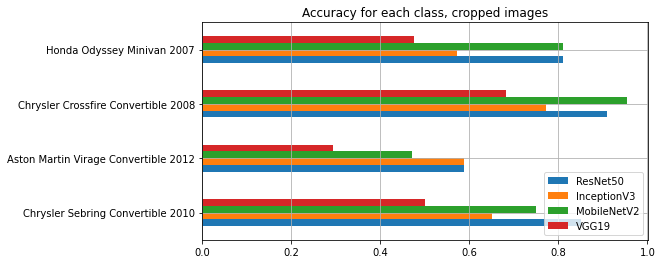

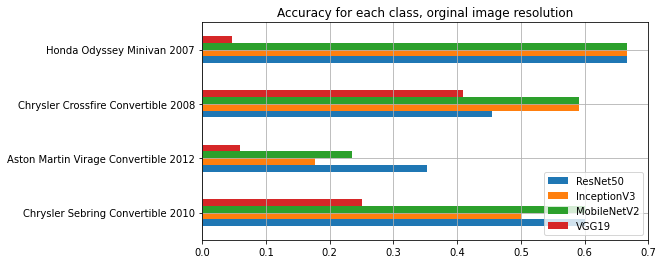

In [74]:
images_paths = get_images_paths(model_name, classes_accuracy_crop_combined, classes_accuracy_original_combined,
                                mode_set=mode_set,
                                mode_categories=mode_categories,
                                number_of_categories=number_of_categories,
                                number_of_samples_in_each_category=number_of_samples_in_each_category)

In [75]:
models = [resnet50_model, inception_v3_model, mobilenet_v2_model, vgg19_model]

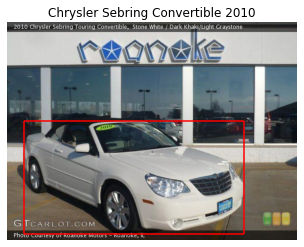

ResNet50 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chevrolet Malibu Sedan 2007 (incorrect)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Mercedes-Benz 300-Class Convertible 1993 (incorrect)
Original version of an image: Audi RS 4 Convertible 2008 (incorrect)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chrysler Sebring Convertible 2010 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Chrysler PT Cruiser Convertible 2008 (incorrect)
Original version of an image: Nissan NV Passenger Van 2012 (incorrect)
-----------------------------------------------------------


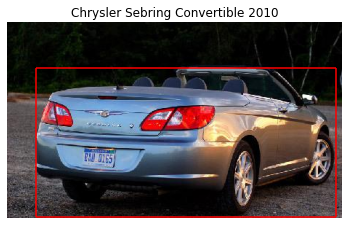

ResNet50 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chrysler Sebring Convertible 2010 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: BMW 1 Series Convertible 2012 (incorrect)
Original version of an image: BMW 6 Series Convertible 2007 (incorrect)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chrysler Sebring Convertible 2010 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: BMW M6 Convertible 2010 (incorrect)
Original version of an image: BMW M6 Convertible 2010 (incorrect)
-----------------------------------------------------------


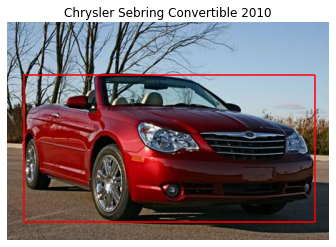

ResNet50 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chrysler Sebring Convertible 2010 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chrysler Sebring Convertible 2010 (correct)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Chrysler Sebring Convertible 2010 (correct)
Original version of an image: Chrysler Sebring Convertible 2010 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Eagle Talon Hatchback 1998 (incorrect)
Original version of an image: Chrysler PT Cruiser Convertible 2008 (incorrect)
-----------------------------------------------------------


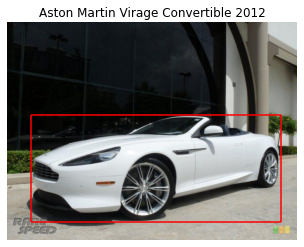

ResNet50 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Aston Martin Virage Convertible 2012 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Aston Martin Virage Convertible 2012 (correct)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Mercedes-Benz S-Class Sedan 2012 (incorrect)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Eagle Talon Hatchback 1998 (incorrect)
-----------------------------------------------------------


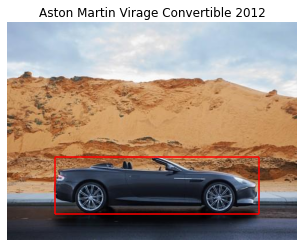

ResNet50 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: HUMMER H3T Crew Cab 2010 (incorrect)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Bentley Continental Supersports Conv. Convertible 2012 (incorrect)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Aston Martin V8 Vantage Convertible 2012 (incorrect)
Original version of an image: Geo Metro Convertible 1993 (incorrect)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Audi S5 Convertible 2012 (incorrect)
Original version of an image: HUMMER H3T Crew Cab 2010 (incorrect)
-----------------------------------------------------------


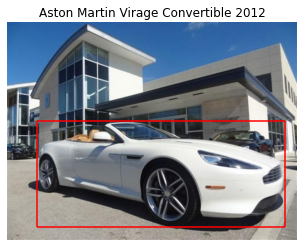

ResNet50 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Aston Martin Virage Convertible 2012 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: Chevrolet Camaro Convertible 2012 (incorrect)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Aston Martin Virage Convertible 2012 (correct)
Original version of an image: BMW M6 Convertible 2010 (incorrect)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Fisker Karma Sedan 2012 (incorrect)
Original version of an image: Mercedes-Benz 300-Class Convertible 1993 (incorrect)
-----------------------------------------------------------


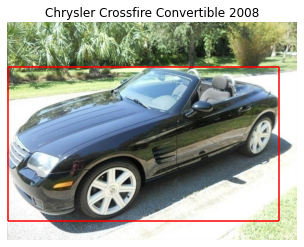

ResNet50 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chrysler Crossfire Convertible 2008 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chrysler Crossfire Convertible 2008 (correct)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chrysler Crossfire Convertible 2008 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Ford Focus Sedan 2007 (incorrect)
Original version of an image: Mercedes-Benz 300-Class Convertible 1993 (incorrect)
-----------------------------------------------------------


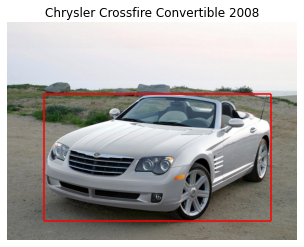

ResNet50 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chrysler Crossfire Convertible 2008 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chevrolet Camaro Convertible 2012 (incorrect)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chrysler Crossfire Convertible 2008 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Chrysler Crossfire Convertible 2008 (correct)
-----------------------------------------------------------


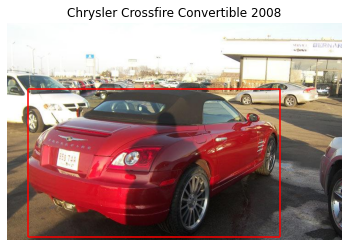

ResNet50 model predictions:
Cropped version of an image: Chrysler Crossfire Convertible 2008 (correct)
Original version of an image: Ford Mustang Convertible 2007 (incorrect)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Ford Mustang Convertible 2007 (incorrect)
Original version of an image: Jaguar XK XKR 2012 (incorrect)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Ford Mustang Convertible 2007 (incorrect)
Original version of an image: Ford Mustang Convertible 2007 (incorrect)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Ford GT Coupe 2006 (incorrect)
Original version of an image: Chevrolet Camaro Convertible 2012 (incorrect)
-----------------------------------------------------------


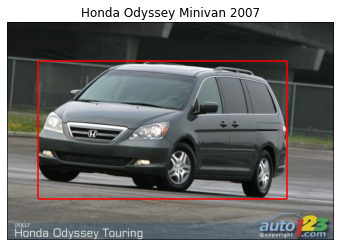

ResNet50 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Ram C/V Cargo Van Minivan 2012 (incorrect)
Original version of an image: GMC Acadia SUV 2012 (incorrect)
-----------------------------------------------------------


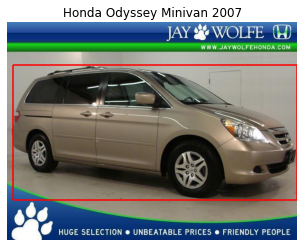

ResNet50 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Ford Freestar Minivan 2007 (incorrect)
-----------------------------------------------------------


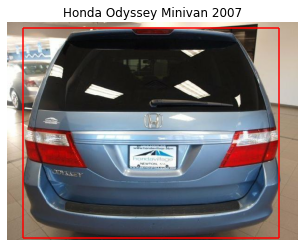

ResNet50 model predictions:
Cropped version of an image: Chevrolet Traverse SUV 2012 (incorrect)
Original version of an image: Honda Odyssey Minivan 2012 (incorrect)
-----------------------------------------------------------
InceptionV3 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2007 (correct)
Original version of an image: Honda Odyssey Minivan 2007 (correct)
-----------------------------------------------------------
MobileNetV2 model predictions:
Cropped version of an image: Honda Odyssey Minivan 2012 (incorrect)
Original version of an image: Honda Odyssey Minivan 2012 (incorrect)
-----------------------------------------------------------
VGG19 model predictions:
Cropped version of an image: GMC Terrain SUV 2012 (incorrect)
Original version of an image: GMC Acadia SUV 2012 (incorrect)
-----------------------------------------------------------


In [76]:
for path in images_paths:
    visualize_making_predictions(image_path=path, 
                                 model_names=names,
                                 models=models, 
                                 class_names=class_names,
                                 models_attributes=models_attributes,
                                 annos_file=annos_file)

<a name='15'></a>
## 15. Summary
In this work, I presented an approach to deal with car brands recognition task. Data exploration was performed, as well as preprocessing of a dataset. Moreover, two hypothesis were raised and then tested.
Following models were trained and evaluated on test set (cropped and original image resolution):
- ResNet50 (accuracy on test set: cropped - 69.8%, original - 42.1%)
- InceptionV3 (accuracy on test set: cropped - 60.1%, original - 42.3%)
- MobileNetV2 (accuracy on test set: cropped - 62.6%, original - 38.5%)
- VGG19 (accuracy on test set: cropped - 50.2%, original - 25.7%)

And two of them were fine-tuned:
- ResNet50 (accuracy on test set: cropped - 79.6%, original - 54.8%)
- MobileNetV2 (accuracy on test set: cropped - 74.6%, original - 51.1%)

Visualization of training process presented. Moreover, performance on two types of test sets has been examined with respect to each category.

At the end of this notebook, making prediction was visualized on examples from test set.

What can be done, to improve model accuracy:
- add more samples to training set
- data augmentation (new synthetic examples)
- training models in different way -  use learning rate decay, fine-tune more layers from base model